# CS375 - Tutorial 1
### Welcome to tutorial 1! This tutorial will introduce you to basic MongoDB, Tensorflow, and tfutils functions and commands. We will learn how to setup a MongoDB database, and connect, read and write to it. We will then give you a brief refresher on Tensorflow, show you how to read data not only from feed dicts but also TFRecords and build a simple Multi-Layer Perceptron (MLP). We will also show you how to create TFRecord files out of your own data. Finally, we will show you how to use tfutils which puts all pieces together into one coherent framework.

## 1.) Using MongoDB with pymongo
### First we will learn how to use MongoDB. We will start with setting up a MongoDB database. We assume that you have installed MongoDB following any of the instructions that you can find online. A principled way to setup a MongoDB database is to use a config file. A mongodb.conf file needs to have the following content:

\# Where to store the data.  
dbpath=/mongodb/mongodb  
\# Where to log  
logpath=/mongodb/mongodb/mongodb.log  
\# IPs and ports your database is broadcasting to (127.0.0.1 is localhost).  
bind_ip = 127.0.0.1  
port = 24444

### That's it! That's all we need to setup and start a MongoDB database. If any of these is not defined MongoDB will fall back to its default settings. We can setup and start a MongoDB database with the following command:
`sudo mongod --config=mongodb.conf --quiet&`

### Now that we have setup our database, let's try to connect to it using the python interface "pymongo". Therefore, we need to specify the port and the host of the database we want to connect to:

##### Note commands [6] - [12] will yield different results on the cluster and might throw errors if you haven't trained your AlexNet model in the database and collection that I specified here. Adjust your path, databases etc. according to your experiment settings. This holds true for the whole tutorial.

In [1]:
import pymongo as pm
import numpy as np

port = 24444
host = 'localhost'
connection = pm.MongoClient(port = port, host = host)

### To test if we have successfully connected to our database let's print out the last 3 database names.

In [4]:
print(connection.database_names()[-6:])

[u'imagenet', u'local', u'mnist', u'mnist_simple_exp1___RECENT', u'tasks', u'uncertain_agent']


### Now let's say we are interested in the contents of "imagenet". As all Mongo data is returned in form of a dictionary we can access "future prediction" as follows and look up it's collections:

In [5]:
database = connection['imagenet']
print(database.collection_names())

[u'alexnet.files', u'alexnet.chunks']


### Let's dig deeper and have a look at "alexnet.files". As we have learned in the last lecture we have reached the level where we store our experiments uniquely identified by "exp_id". So let's find all unique "exp_id" in the "alexnet.files" collection.

In [6]:
collection = database['alexnet.files']
collection.distinct('exp_id')

[u'experiment_0', u'experiment_1', u'experiment_2']

### In order to find all entries with e. g. "experiment_1" we need to query the database for it's "exp_id". So we formulate a search query and use it to retrieve the entry as follows:

In [7]:
query = {'exp_id': 'experiment_1'}
entries = collection.find(query)
print(entries.count())

2760


### We have found 2760 entries with "exp_id" "experiment_1", some of which belong to training data, and some of which belong to validation data, which I know as I have created those entries with tfutils. Let's have a look at the contents of the first entry:

In [8]:
entries[0]

{u'_id': ObjectId('59cea1c51742f9204655a750'),
 u'duration': 49.862842082977295,
 u'exp_id': u'experiment_1',
 u'params': {u'dont_run': False,
  u'inter_op_parallelism_threads': 40,
  u'learning_rate_params': {u'boundaries': [150000, 300000, 450000],
   u'func': {u'active_branch': u'master',
    u'active_branch_in_origin': True,
    u'clean': False,
    u'commit': u'0b381e860e660586cf181ebdc7643d5c8bdbff22',
    u'commit_in_log': True,
    u'git_dir': u'/home/mrowca/workspace/cs375-private/.git',
    u'modname': u'__main__',
    u'objname': u'<lambda>',
    u'remote_urls': [u'https://github.com/neuroailab/cs375-private.git'],
    u'source_path': u'train_imagenet.py'},
   u'values': [0.01, 0.005, 0.001, 0.0005]},
  u'load_params': {u'collname': u'alexnet',
   u'dbname': u'imagenet',
   u'do_restore': False,
   u'exp_id': u'experiment_1',
   u'host': u'localhost',
   u'load_query': None,
   u'port': 24444},
  u'log_device_placement': False,
  u'loss_params': {u'agg_func': {u'modname': u'

### We see that the entry consists of a bunch of keys that store information about the trained model and training results. Now let's say we want to access only those entries that actually contain training results. In order to do this we have to formuate a new database query where we use the "$exists" keyword to signal that "train_results" has to exist in any entry that gets returned:

In [9]:
query_train = {'exp_id': 'experiment_1', 'train_results': {'$exists' : True}}
train_entries = collection.find(query_train)
train_entries[0]

{u'_id': ObjectId('59cea1c51742f9204655a750'),
 u'duration': 49.862842082977295,
 u'exp_id': u'experiment_1',
 u'params': {u'dont_run': False,
  u'inter_op_parallelism_threads': 40,
  u'learning_rate_params': {u'boundaries': [150000, 300000, 450000],
   u'func': {u'active_branch': u'master',
    u'active_branch_in_origin': True,
    u'clean': False,
    u'commit': u'0b381e860e660586cf181ebdc7643d5c8bdbff22',
    u'commit_in_log': True,
    u'git_dir': u'/home/mrowca/workspace/cs375-private/.git',
    u'modname': u'__main__',
    u'objname': u'<lambda>',
    u'remote_urls': [u'https://github.com/neuroailab/cs375-private.git'],
    u'source_path': u'train_imagenet.py'},
   u'values': [0.01, 0.005, 0.001, 0.0005]},
  u'load_params': {u'collname': u'alexnet',
   u'dbname': u'imagenet',
   u'do_restore': False,
   u'exp_id': u'experiment_1',
   u'host': u'localhost',
   u'load_query': None,
   u'port': 24444},
  u'log_device_placement': False,
  u'loss_params': {u'agg_func': {u'modname': u'

### Again, we obtain a list of entries out of which all contain "train_results".  We printed the content of the first returned entry and we can observe that although we requested only entries that contain "train_results" all of the entries data was returned and not only "train_results". If we want Mongo to return only "train_results" in each entry we have to use a projection as follows: 

In [10]:
train_entries = collection.find(query_train, projection = ['train_results'])
train_entries[0]

{u'_id': ObjectId('59cea1c51742f9204655a750'),
 u'train_results': [{u'learning_rate': 0.009999999776482582,
   u'loss': 6.9073381423950195},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.903197288513184},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.915280342102051},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.925808906555176},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.91734504699707},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.917638301849365},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.92468786239624},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.923411846160889},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.914703369140625},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.910067558288574},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.914397716522217},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.917898654937744},
  {u'learning_rate': 0.009999999776482582, u'loss': 6.916857242584228

### As we can see we have now successfully retrieved "train_results" only, except for the unique identifier "_id" which always gets returned. These "train_results" entries were saved every couple of iterations while training a model in tfutils and for instance contain the training loss. Using this training data we can now easily construct a vector that contains the training loss over time by using a simple list comprehension:

In [11]:
train_entries = collection.find(query_train, projection = ['train_results'])
loss = np.array([results['loss'] for entry in train_entries for results in entry['train_results']])

### We can now go ahead and plot the loss:

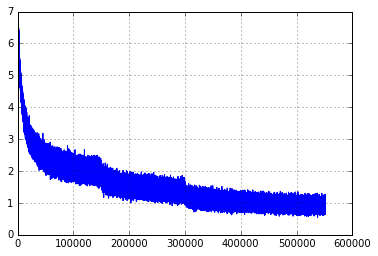

In [12]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.plot(loss)
plt.grid()

### Inserting records into MongoDB as easy as reading data from the database. You simply can simply use the "insert_one()" method as follows:

In [13]:
# entry has to be a dictionary
entry_1 = {'value': 10.1}
coll = connection['test_db']['test_coll']
coll.insert_one(entry_1)

### And if we now query the "test_coll" collection we can see that "entry_1" has been stored in the database:

In [14]:
coll = connection['test_db']['test_coll']
coll.find({'value': {'$exists' : True}})[0]

{u'_id': ObjectId('59dea34d1742f953d01dc56a'), u'value': 10.1}

### Now let's insert two more entries and sort them by the "value" field:

In [15]:
entry_2 = {'value': 4.2}
entry_3 = {'value': 8.3}

coll = connection['test_db']['test_coll']
coll.insert_many([entry_2, entry_3])

entries = coll.find({'value': {'$exists' : True}}, projection=['value'])
entries = [entry for entry in entries]
print('Not sorted:')
for entry in entries:
    print(entry['value'])

entries = coll.find({'value': {'$exists' : True}}, projection=['value']).sort([('value',pm.ASCENDING)])
entries = [entry for entry in entries]
print('Sorted:')
for entry in entries:
    print(entry['value'])

Not sorted:
10.1
4.2
8.3
Sorted:
4.2
8.3
10.1


### Finally, let's clean up and delete some entries, the collection and database to conclude the tutorial on pymongo and MongoDB:

In [16]:
# remove entry with field 'value' = 10.1
#coll.remove({'value' : 10.1}, {'justOne': True})
coll.delete_one({'value' : 10.1})

# remove collection
connection['test_db'].drop_collection('test_coll')

# remove database
connection.drop_database('test_db')

## 2.) Creating a simple model in Tensorflow
### We will now move on to a brief exercise on Tensorflow. We will keep this section short since most of you should be familiar with Tensorflow by now. In the following, we will talk about how to create a Tensorflow graph, execute the graph in a session, variables and variable scopes, placeholders and feed dicts.

### First we will define a 3 layer MLP with 3 input neurons, 20 hidden neurons, and 3 output neurons in Tensorflow:

In [18]:
import tensorflow as tf
import numpy as np

# input placeholder
input_placeholder = tf.placeholder(tf.float32, shape=[None, 3])
# trainable variables randomly initialized
W1 = tf.Variable(tf.random_normal(shape=[3,20]), tf.float32)
b1 = tf.Variable(tf.random_normal(shape=[20,]), tf.float32)
W2 = tf.Variable(tf.random_normal(shape=[20,3]), tf.float32)
b2 = tf.Variable(tf.random_normal(shape=[3,]), tf.float32)
# hidden layer
h = tf.nn.sigmoid(tf.matmul(input_placeholder, W1) + b1)
# output
out = tf.matmul(h, W2) + b2

### To run one forward pass of this randomly initialized MLP with some random data we first have to create a session and initialize all variables:

In [19]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
# creates a session and allocates memory on GPU 1
sess = tf.Session()
# initialize all variables
init_op = tf.global_variables_initializer()
sess.run(init_op)

### Then we can execute the forward pass with a call to the session's "run()" method, while specifying the output targets and feeding the input data through the feed_dict parameter to the placeholders:

In [20]:
# create some random input and run forward pass on it
inp = np.random.rand(1, 3).astype(np.float32)
result = sess.run(out, feed_dict={input_placeholder: inp})
print(result)

[[-0.30483484 -1.43704009  0.14522044]]


### Now let's train this MLP to regress some arbitrary function "y". In order to do that we need to define a loss and an optimizer that minimizes that loss:

In [21]:
# the input x and output y
x = np.random.rand(1000,3).astype(np.float32)
y = x ** 2 + 3
# labels placeholder
labels_placeholder = tf.placeholder(tf.float32, shape=[None, 3])
# simple l2-loss
loss = tf.nn.l2_loss(out - labels_placeholder)
# Gradient descent optimizer
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

### Let's train for 1,000 steps...

In [22]:
from tqdm import trange
for i in trange(1000):
    idx = np.random.RandomState(0).permutation(1000)[:32]
    inputs = x[idx]
    labels = y[idx]
    sess.run(train_step, feed_dict={input_placeholder: inputs, labels_placeholder: labels})

100%|██████████| 1000/1000 [00:01<00:00, 795.06it/s]


### ... and evaluate the result:

In [23]:
inp = np.random.rand(1, 3).astype(np.float32)
ground_truth = inp ** 2 + 3
prediction = sess.run(out, feed_dict={input_placeholder: inp})
print('Ground truth', ground_truth) 
print('Prediction', prediction)

('Ground truth', array([[ 3.36996603,  3.08501911,  3.10821509]], dtype=float32))
('Prediction', array([[ 3.5108726 ,  3.12152052,  3.11799765]], dtype=float32))


### Looking good! Our model approximates the function "y" pretty well! However there's a better way to feed data to your tensorflow model which comes in particularly handy when working with large-scale datasets: TFRecords!

## 3.) Using TFRecords

### TFRecord is a file format for Tensorflow used to store data in its flattened, serialized byte format. Any type of data can be stored in TFRecords as long as its serializable. Tensorflow implements a TFRecordReader that is able to read this file format into a Tensorflow graph. In Tensorflow queues are used to allow for an asynchronous data reading and model execution. Queues also enables the use of multiple threads for data reading. TFRecords store data sequentially, and only allow for it to be read in sequential order. Random access is not possible. This makes the data loading from disk super fast but makes data randomization impossible. Thus, in order to randomize the input data as it is usually necessary to train machine learning models, there needs to be a separate postprocessing stage that takes care of the randomization. The nice thing about using queues is that one can simply shuffle the data after loading and before handing it over to the model for the feedforward pass. 

### Thus in summary, TFRecords together with file and data queues provide an elegant framework to load large amounts of data in a short period of time which is crucial at a time where GPUs are no longer the bottleneck for training large-scale models and the training speed of a network is dependent on the data loading speed from hard drives. 

### In the following, we will first show you how to write TFRecords. So let's construct some arbitrary data and save it on disk in the tfrecords format:

In [24]:
# Arbitrary data with some arbitrary attributes
data = {
    'idx': np.array(range(100)).astype(np.int32),
    'values': np.array(range(100)).astype(np.int32)[::-1].astype(np.float32),
    'labels': np.array(['large', 'scale', 'neural', 'network', 'modeling', 'for', 'neuroscience', 'is', 'the', 'best!'] * 10)
    }

# Make sure all attributes are of the same length
for k in data:
    assert len(data[k]) == len(data[data.keys()[0]])

# We are storing our data as byte strings
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

# Create tfrecord file
file_path = '/mnt/fs0/mrowca/notebooks/mrowca/myfile.tfrecords'
writer = tf.python_io.TFRecordWriter(file_path)
for i in range(len(data[data.keys()[0]])):
    # Construct the datum to be written
    feature = {}
    for k in data:
        # serialize the data
        feature[k] = _bytes_feature(data[k][i].tostring())
    datum = tf.train.Example(features = tf.train.Features(feature = feature))
    # Write the data
    writer.write(datum.SerializeToString())
# Close the writer
writer.close()

### Now let's read the data that we have written. There are two ways to do that. One that requires you to use a session as the "tf.TFRecordReader()" is part of the Tensorflow graph, and one that you can use to view the data stored inside of TFRecords without constructing a graph: "tf.python_io.tf_record_iterator()". While the first method is actually used when running large-scale experiments as it can be easily parallelized using multiple queue runners which enables faster loading, the second method is useful for debugging purposes. So let's use "tf.python_io.tf_record_iterator()" to have a brief look at our newly written TFRecords file to see if it has been written correctly.

In [25]:
# Open the tfrecord file
file_path = '/mnt/fs0/mrowca/notebooks/mrowca/myfile.tfrecords'
tfrec = tf.python_io.tf_record_iterator(path=file_path)
datum = tf.train.Example()
# Go to the first entry and decode it
datum.ParseFromString(tfrec.next())
# Print the attribute names in this record
print('Attributes:')
print(datum.features.feature.keys())

Attributes:
[u'labels', u'values', u'idx']


In [26]:
# Access the attributes and decode them to the correct data type
idx = np.fromstring(datum.features.feature['idx'].bytes_list.value[0], dtype=np.int32)
value = np.fromstring(datum.features.feature['values'].bytes_list.value[0], dtype=np.float32)
label = datum.features.feature['labels'].bytes_list.value[0]
print('idx:', idx)
print('value:', value)
print('label:', label)

('idx:', array([0], dtype=int32))
('value:', array([ 99.], dtype=float32))
('label:', 'large')


### Everything looks correct for the first entry. If we would want to examine the second entry we would simply call "tfrec.next()" again and we would get the second entry and so on. We won't do that here though and instead assume the tfrecord has been correctly written. 

### Now let's use the first method "tf.TFRecordReader()" to read data into a Tensorflow graph that simply outputs the data. We will need "tf.TFRecordReader()" as well as a file queue for that which we can use as follows:

In [27]:
import tensorflow as tf

batch_size = 1
# construct the filename queue that holds all file names in our case only "myfile.tfrecords"
file_path = '/mnt/fs0/mrowca/notebooks/mrowca/myfile.tfrecords'
filename_queue = tf.train.string_input_producer([file_path])

# setup the reader and read the first batch_size examples
reader = tf.TFRecordReader()
_, serialized_example = reader.read_up_to(filename_queue, batch_size)

# decode the example
features = tf.parse_example(
        serialized_example, features={
        'idx': tf.FixedLenFeature([], tf.string),
        'values': tf.FixedLenFeature([], tf.string),
        'labels': tf.FixedLenFeature([], tf.string),
        })
idx_record = tf.decode_raw(features['idx'], tf.int32)
values_record = tf.decode_raw(features['values'], tf.float32)
labels_record = features['labels']

# enqueue the example onto a random shuffle queue for shuffling and add a queue runner that takes care of this
queue = tf.RandomShuffleQueue(dtypes=[tf.int32, tf.float32, tf.string],
                              capacity=10, 
                              min_after_dequeue=5, 
                              seed = 5)
enqueue_op = queue.enqueue([idx_record, values_record, labels_record])
tf.train.queue_runner.add_queue_runner(tf.train.queue_runner.QueueRunner(queue, [enqueue_op]))

# define the output as dequeuing from the random shuffle queue, so we can use it as a target in sess.run
output = queue.dequeue()

# initialize variables and start queue runners
sess = tf.Session()
init_op = tf.global_variables_initializer()
sess.run(init_op)                                             
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=sess, coord=coord)

# run forward pass 
data = sess.run(output)

# print results
print('idx:', data[0][0])
print('value:', data[1][0])
print('label:', data[2][0])

# stop the queue runners
coord.request_stop()
coord.join(threads)

('idx:', array([1], dtype=int32))
('value:', array([ 98.], dtype=float32))
('label:', 'scale')


### To summarize, we first created a filename_queue that holds the filenames of all TFRecords we want to load data from. We then used a TFRecordReader to read one example off a TFRecords file on the filename_queue. We decoded this example into its original attributes. We enqueued those attributes onto another queue that we used to shuffle our data using another queue runner. We then dequeued an example from the queue as output, which concluded the construction of our graph. To run the graph, we initialized all variables and queue runners and called the "run()" method, which allowed us to retrieve the outputs and print them out. Finally, after we were done, we had to stop the queue runner threads.  TFUtils implements exactly this procedure and we will have a closer look how to use it in the next section.

## 4.) Using TFUtils

### TFUtils, in one way or another, uses everything we have discussed so far. It is a great framework to keep track of your experiments in a database. You can train a model, restore its weights, test it, modify it, extract intermediate features, or do all at once while TFUtils is keeping track of the developmental trajectory of your network. 

### In the following, we will first show you how to train a model in TFUtils. Therefore, let's use the standard MNIST example:

In [28]:
from __future__ import division
from tfutils import base, data, optimizer, utils

# delete exp1
connection['mnist']['simple.files'].delete_many({'exp_id' : 'exp1'})

def mnist_model(inputs, train=True, **kwargs):
    # trainable variables randomly initialized
    with tf.variable_scope("mnist"):
        W1 = tf.get_variable('W1', [784,128], tf.float32, tf.random_normal_initializer(stddev=0.1))
        b1 = tf.get_variable('b1', [128], tf.float32, tf.random_normal_initializer(stddev=0.1))
        W2 = tf.get_variable('W2', [128,32], tf.float32, tf.random_normal_initializer(stddev=0.1))
        b2 = tf.get_variable('b2', [32], tf.float32, tf.random_normal_initializer(stddev=0.1))
        W3 = tf.get_variable('W3', [32,10], tf.float32, tf.random_normal_initializer(stddev=0.1))
        b3 = tf.get_variable('b3', [10], tf.float32, tf.random_normal_initializer(stddev=0.1))
        
        # hidden layers
        h1 = tf.nn.sigmoid(tf.matmul(inputs['images'], W1) + b1, name='hidden1')
        h2 = tf.nn.sigmoid(tf.matmul(h1, W2) + b2, name='hidden2')
        # output
        output = tf.matmul(h2, W3) + b3

    return output, {}

params = {}

params['load_params'] = {
    'do_restore': False}

params['save_params'] = {
    'host': 'localhost',
    'port': 24444,
    'dbname': 'mnist',
    'collname': 'simple',
    'exp_id': 'exp1',
    'save_valid_freq': 200,
    'save_filters_freq': 100,
    'cache_filters_freq': 100}

params['train_params'] = {
    'data_params': {'func': data.MNIST,
                    'batch_size': 256,
                    'group': 'train',
                    'n_threads': 1},
    'queue_params': {'queue_type': 'random',
                     'batch_size': 256},
    'num_steps': 100}

params['model_params'] = {
    'func': mnist_model} 

params['learning_rate_params'] = {
    'learning_rate': 0.5,
    'decay_steps': 500,
    'decay_rate': 0.95,
    'staircase': True}

params['optimizer_params'] = {
    'func': optimizer.ClipOptimizer,
    'optimizer_class': tf.train.MomentumOptimizer,
    'momentum': 0.9,
    'clip': True,
}

params['loss_params'] = {
    'targets': ['labels'],
    'loss_per_case_func': tf.nn.sparse_softmax_cross_entropy_with_logits,
    'agg_func': tf.reduce_mean
}

params['skip_check'] = True

base.train_from_params(**params)

INFO:tfutils:No seed specified for model 0... Defaulting to seed: 0.
INFO:tfutils:No prefix specified for model 0... Defaulting to prefix: model_0.
INFO:tfutils:No devices specified for model 0... Defaulting to gpus: ['/gpu:0'].
INFO:tfutils:thres_loss not specified for model 0... Defaulting thres_loss to: 100.
INFO:tfutils:train_loop not specified for model 0... Using default training loop.
INFO:tfutils:validate_fist not specified for model 0... Defaulting validate_first to: True.
INFO:tfutils:minibatch_size not specified for training data_params... Defaulting minibatch_size to: 256 (identical to the batch size).


Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


INFO:tfutils:Initialized from scratch first
INFO:tfutils:Training beginning ...


mnist/b2/Momentum
global_step
mnist/W1/Momentum
Variable_5
mnist/b3/Momentum
mnist/W3/Momentum
mnist/b1
mnist/b2
mnist/b3
Variable_3
Variable_2
Variable_1
mnist/W2/Momentum
Variable
Variable_4
mnist/b1/Momentum
mnist/W3
mnist/W2
mnist/W1


INFO:tfutils:Saving model with path prefix /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint ... 
INFO:tfutils:Step 1 (126 ms) -- loss: 2.3385, learning_rate: 0.5000
INFO:tfutils:Step 2 (75 ms) -- loss: 2.3385, learning_rate: 0.5000
INFO:tfutils:Step 3 (7 ms) -- loss: 2.2933, learning_rate: 0.5000
INFO:tfutils:Step 4 (231 ms) -- loss: 2.3269, learning_rate: 0.5000
INFO:tfutils:... done saving with path prefix /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-0
INFO:tfutils:Putting filters into <gridfs.GridFS object at 0x7fde33fb4d90> database
INFO:tfutils:Step 5 (655 ms) -- loss: 2.3195, learning_rate: 0.5000
INFO:tfutils:Step 6 (64 ms) -- loss: 2.3355, learning_rate: 0.5000
INFO:tfutils:... done putting filters into database.
INFO:tfutils:Step 7 (92 ms) -- loss: 2.2811, learning_rate: 0.5000
INFO:tfutils:Step 8 (6 ms) -- loss: 2.2912, learning_rate: 0.5000
INFO:tfutils:Step 9 (67 ms) -- loss: 2.2876, learning_rate: 0.5000
INFO:tfutils:Step 10 (6 ms) -

[[ObjectId('59dea3a61742f953d01dc56e'), ObjectId('59dea3a81742f953d01dc574')]]

### As you can see, all you need to train a model in TFUtils is to define "params" and call "base.train_from_params(**params"). TFUtils then executes the specified experiment, in this case training MNIST on a 10-way digit recognition task. As you can see the loss decreases, and at the end of the experiment the trained model is saved in the database as specified by "save_params". Now let's load the trained model from the database and test it on the validation set using TFUtils:

In [29]:
def top1_func(inputs, outputs): 
    return {'top1': tf.nn.in_top_k(outputs, inputs['labels'], 1)}

def online_agg(agg_res, res, step):
    """
    Appends the value for each key
    """
    if agg_res is None:
        agg_res = {k: [] for k in res}
    for k, v in res.items():
        agg_res[k].append(v)
    return agg_res

def agg_mean(x):
    return {k: np.mean(v) for k, v in x.items()}

params = {}

params['load_params'] = {
    'host': 'localhost',
    'port': 24444,
    'dbname': 'mnist',
    'collname': 'simple',
    'exp_id': 'exp1',
    'do_restore': True}

params['validation_params'] = {'valid0': {
    'data_params': {'func': data.MNIST,
                    'batch_size': 100,
                    'group': 'test',
                    'n_threads': 1},
    'queue_params': {'queue_type': 'fifo',
                     'batch_size': 100},
    'targets': {'func': top1_func},
    'num_steps': 100,
    'agg_func': agg_mean,
    'online_agg_func': online_agg,}}

params['model_params'] = {
    'func': mnist_model}

params['skip_check'] = True

base.test_from_params(**params)

# Extract record from database
q_val = {'exp_id' : 'exp1', 'validation_results' : {'$exists' : True}, 'validates': {'$exists': True}}
val_steps = connection['mnist']['simple.files'].find(q_val, projection = ['validation_results'])
top1 = [val_steps[i]['validation_results']['valid0']['top1'] 
        for i in range(val_steps.count())]
print(top1)

INFO:tfutils:No seed specified for model 0... Defaulting to seed: 0.
INFO:tfutils:No prefix specified for model 0... Defaulting to prefix: model_0.
INFO:tfutils:No devices specified for model 0... Defaulting to gpus: ['/gpu:0'].
INFO:tfutils:Initialized from scratch first
INFO:tfutils:Loading checkpoint from mnist.simple.files
INFO:tfutils:Cache file found at /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-100, using that to load


Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


INFO:tfutils:Loading checkpoint from mnist.simple.files
INFO:tfutils:Cache file found at /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-100, using that to load
INFO:tfutils:Restoring variables from record 59dea3a81742f953d01dc574 (step 100)...
INFO:tfutils:Saved Vars:
['global_step', 'mnist/W1/Momentum', 'mnist/b3/Momentum', 'mnist/b2', 'mnist/W3/Momentum', 'mnist/b1', 'Variable_5', 'mnist/b3', 'Variable_3', 'mnist/W1', 'Variable_1', 'mnist/W2/Momentum', 'Variable', 'Variable_4', 'mnist/b1/Momentum', 'mnist/W3', 'mnist/W2', 'mnist/b2/Momentum', 'Variable_2']
INFO:tfutils:No variable mapping specified.
INFO:tfutils:Saved shapes:
{'Variable_4': [32, 10], 'global_step': [], 'mnist/W1/Momentum': [784, 128], 'mnist/b3/Momentum': [10], 'mnist/W3/Momentum': [32, 10], 'mnist/b1': [128], 'mnist/b2': [32], 'mnist/b3': [10], 'Variable_3': [32], 'mnist/b2/Momentum': [32], 'Variable_1': [128], 'mnist/W2/Momentum': [128, 32], 'Variable': [784, 128], 'Variable_5': [10], 'mnist/b1/

[0.8994]


### Of course you can also put train and validation together. So let's restore the training, train some more and validate every 100 steps:

In [30]:
params = {}

params['load_params'] = {
    'host': 'localhost',
    'port': 24444,
    'dbname': 'mnist',
    'collname': 'simple',
    'exp_id': 'exp1',
    'do_restore': True}

params['save_params'] = {
    'host': 'localhost',
    'port': 24444,
    'dbname': 'mnist',
    'collname': 'simple',
    'exp_id': 'exp1',
    'save_valid_freq': 100,
    'save_filters_freq': 100,
    'cache_filters_freq': 100}

params['train_params'] = {
    'data_params': {'func': data.MNIST,
                    'batch_size': 256,
                    'group': 'train',
                    'n_threads': 1},
    'queue_params': {'queue_type': 'random',
                     'batch_size': 256},
    'num_steps': 3000}

params['learning_rate_params'] = {
    'learning_rate': 0.5,
    'decay_steps': 500,
    'decay_rate': 0.95,
    'staircase': True}

params['optimizer_params'] = {
    'func': optimizer.ClipOptimizer,
    'optimizer_class': tf.train.MomentumOptimizer,
    'momentum': 0.9,
    'clip': True,
}

params['loss_params'] = {
    'targets': ['labels'],
    'loss_per_case_func': tf.nn.sparse_softmax_cross_entropy_with_logits,
    'agg_func': tf.reduce_mean
}

params['validation_params'] = {'valid0': {
    'data_params': {'func': data.MNIST,
                    'batch_size': 100,
                    'group': 'test',
                    'n_threads': 1},
    'queue_params': {'queue_type': 'fifo',
                     'batch_size': 100},
    'targets': {'func': top1_func},
    'num_steps': 100,
    'agg_func': agg_mean,
    'online_agg_func': online_agg,}}

params['model_params'] = {
    'func': mnist_model}

params['skip_check'] = True

base.train_from_params(**params)

# Extract record from database
q_val = {'exp_id' : 'exp1', 'validation_results' : {'$exists' : True}}
val_steps = connection['mnist']['simple.files'].find(q_val, projection = ['validation_results'])
top1 = [val_steps[i]['validation_results']['valid0']['top1'] 
        for i in range(val_steps.count())]
print(top1)

INFO:tfutils:No seed specified for model 0... Defaulting to seed: 0.
INFO:tfutils:No prefix specified for model 0... Defaulting to prefix: model_0.
INFO:tfutils:No devices specified for model 0... Defaulting to gpus: ['/gpu:0'].
INFO:tfutils:thres_loss not specified for model 0... Defaulting thres_loss to: 100.
INFO:tfutils:train_loop not specified for model 0... Using default training loop.
INFO:tfutils:validate_fist not specified for model 0... Defaulting validate_first to: True.
INFO:tfutils:minibatch_size not specified for training data_params... Defaulting minibatch_size to: 256 (identical to the batch size).


Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


INFO:tfutils:Initialized from scratch first
INFO:tfutils:Loading checkpoint from mnist.simple.files
INFO:tfutils:Cache file found at /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-100, using that to load
INFO:tfutils:Restoring variables from record 59dea3a81742f953d01dc574 (step 100)...
INFO:tfutils:Saved Vars:
['global_step', 'mnist/W1/Momentum', 'mnist/b3/Momentum', 'mnist/b2', 'mnist/W3/Momentum', 'mnist/b1', 'Variable_5', 'mnist/b3', 'Variable_3', 'mnist/W1', 'Variable_1', 'mnist/W2/Momentum', 'Variable', 'Variable_4', 'mnist/b1/Momentum', 'mnist/W3', 'mnist/W2', 'mnist/b2/Momentum', 'Variable_2']
INFO:tfutils:No variable mapping specified.
INFO:tfutils:Saved shapes:
{'Variable_4': [32, 10], 'global_step': [], 'mnist/W1/Momentum': [784, 128], 'mnist/b3/Momentum': [10], 'mnist/W3/Momentum': [32, 10], 'mnist/b1': [128], 'mnist/b2': [32], 'mnist/b3': [10], 'Variable_3': [32], 'mnist/b2/Momentum': [32], 'Variable_1': [128], 'mnist/W2/Momentum': [128, 32], 'Variable'

mnist/b2/Momentum
global_step
mnist/W1/Momentum
Variable_5
mnist/b3/Momentum
mnist/W3/Momentum
mnist/b1
mnist/b2
mnist/b3
Variable_3
Variable_2
Variable_1
mnist/W2/Momentum
Variable
Variable_4
mnist/b1/Momentum
mnist/W3
mnist/W2
mnist/W1


INFO:tfutils:... done restoring.
INFO:tfutils:Unrestored Vars:
[]
INFO:tfutils:Training beginning ...
INFO:tfutils:Step 101 (30 ms) -- loss: 0.4063, learning_rate: 0.5000
INFO:tfutils:Step 102 (7 ms) -- loss: 0.3045, learning_rate: 0.5000
INFO:tfutils:Step 103 (5 ms) -- loss: 0.3743, learning_rate: 0.5000
INFO:tfutils:Step 104 (6 ms) -- loss: 0.2990, learning_rate: 0.5000
INFO:tfutils:Step 105 (9 ms) -- loss: 0.2824, learning_rate: 0.5000
INFO:tfutils:Step 106 (4 ms) -- loss: 0.2320, learning_rate: 0.5000
INFO:tfutils:Step 107 (8 ms) -- loss: 0.3891, learning_rate: 0.5000
INFO:tfutils:Step 108 (67 ms) -- loss: 0.3440, learning_rate: 0.5000
INFO:tfutils:Step 109 (5 ms) -- loss: 0.3167, learning_rate: 0.5000
INFO:tfutils:Step 110 (6 ms) -- loss: 0.3700, learning_rate: 0.5000
INFO:tfutils:Step 111 (7 ms) -- loss: 0.3130, learning_rate: 0.5000
INFO:tfutils:Step 112 (8 ms) -- loss: 0.3699, learning_rate: 0.5000
INFO:tfutils:Step 113 (8 ms) -- loss: 0.3488, learning_rate: 0.5000
INFO:tfutils

INFO:tfutils:Step 213 (6 ms) -- loss: 0.1891, learning_rate: 0.5000
INFO:tfutils:Step 214 (6 ms) -- loss: 0.2392, learning_rate: 0.5000
INFO:tfutils:Step 215 (5 ms) -- loss: 0.1600, learning_rate: 0.5000
INFO:tfutils:Step 216 (6 ms) -- loss: 0.2854, learning_rate: 0.5000
INFO:tfutils:Step 217 (5 ms) -- loss: 0.2780, learning_rate: 0.5000
INFO:tfutils:Step 218 (7 ms) -- loss: 0.2459, learning_rate: 0.5000
INFO:tfutils:Step 219 (4 ms) -- loss: 0.1887, learning_rate: 0.5000
INFO:tfutils:Step 220 (5 ms) -- loss: 0.1517, learning_rate: 0.5000
INFO:tfutils:Step 221 (67 ms) -- loss: 0.2702, learning_rate: 0.5000
INFO:tfutils:Step 222 (5 ms) -- loss: 0.2500, learning_rate: 0.5000
INFO:tfutils:Step 223 (6 ms) -- loss: 0.1702, learning_rate: 0.5000
INFO:tfutils:Step 224 (7 ms) -- loss: 0.2043, learning_rate: 0.5000
INFO:tfutils:Step 225 (13 ms) -- loss: 0.2054, learning_rate: 0.5000
INFO:tfutils:Step 226 (6 ms) -- loss: 0.4493, learning_rate: 0.5000
INFO:tfutils:Step 227 (6 ms) -- loss: 0.2810, 

INFO:tfutils:Step 327 (6 ms) -- loss: 0.1307, learning_rate: 0.5000
INFO:tfutils:Step 328 (5 ms) -- loss: 0.1503, learning_rate: 0.5000
INFO:tfutils:Step 329 (6 ms) -- loss: 0.1310, learning_rate: 0.5000
INFO:tfutils:Step 330 (7 ms) -- loss: 0.1277, learning_rate: 0.5000
INFO:tfutils:Step 331 (6 ms) -- loss: 0.1217, learning_rate: 0.5000
INFO:tfutils:Step 332 (6 ms) -- loss: 0.1430, learning_rate: 0.5000
INFO:tfutils:Step 333 (5 ms) -- loss: 0.1656, learning_rate: 0.5000
INFO:tfutils:Step 334 (5 ms) -- loss: 0.1513, learning_rate: 0.5000
INFO:tfutils:Step 335 (6 ms) -- loss: 0.2148, learning_rate: 0.5000
INFO:tfutils:Step 336 (5 ms) -- loss: 0.1214, learning_rate: 0.5000
INFO:tfutils:Step 337 (4 ms) -- loss: 0.1803, learning_rate: 0.5000
INFO:tfutils:Step 338 (23 ms) -- loss: 0.2097, learning_rate: 0.5000
INFO:tfutils:Step 339 (7 ms) -- loss: 0.2282, learning_rate: 0.5000
INFO:tfutils:Step 340 (5 ms) -- loss: 0.2257, learning_rate: 0.5000
INFO:tfutils:Step 341 (8 ms) -- loss: 0.1833, l

INFO:tfutils:Step 441 (6 ms) -- loss: 0.1319, learning_rate: 0.5000
INFO:tfutils:Step 442 (5 ms) -- loss: 0.1281, learning_rate: 0.5000
INFO:tfutils:Step 443 (7 ms) -- loss: 0.1388, learning_rate: 0.5000
INFO:tfutils:Step 444 (6 ms) -- loss: 0.1369, learning_rate: 0.5000
INFO:tfutils:Step 445 (7 ms) -- loss: 0.1284, learning_rate: 0.5000
INFO:tfutils:Step 446 (5 ms) -- loss: 0.0803, learning_rate: 0.5000
INFO:tfutils:Step 447 (6 ms) -- loss: 0.2766, learning_rate: 0.5000
INFO:tfutils:Step 448 (5 ms) -- loss: 0.1137, learning_rate: 0.5000
INFO:tfutils:Step 449 (7 ms) -- loss: 0.1921, learning_rate: 0.5000
INFO:tfutils:Step 450 (6 ms) -- loss: 0.1262, learning_rate: 0.5000
INFO:tfutils:Step 451 (5 ms) -- loss: 0.1425, learning_rate: 0.5000
INFO:tfutils:Step 452 (6 ms) -- loss: 0.2358, learning_rate: 0.5000
INFO:tfutils:Step 453 (6 ms) -- loss: 0.1031, learning_rate: 0.5000
INFO:tfutils:Step 454 (5 ms) -- loss: 0.1326, learning_rate: 0.5000
INFO:tfutils:Step 455 (5 ms) -- loss: 0.1456, le

INFO:tfutils:Step 555 (6 ms) -- loss: 0.1104, learning_rate: 0.4750
INFO:tfutils:Step 556 (6 ms) -- loss: 0.1218, learning_rate: 0.4750
INFO:tfutils:Step 557 (8 ms) -- loss: 0.0702, learning_rate: 0.4750
INFO:tfutils:Step 558 (5 ms) -- loss: 0.1038, learning_rate: 0.4750
INFO:tfutils:Step 559 (5 ms) -- loss: 0.1007, learning_rate: 0.4750
INFO:tfutils:Step 560 (5 ms) -- loss: 0.0900, learning_rate: 0.4750
INFO:tfutils:Step 561 (4 ms) -- loss: 0.1030, learning_rate: 0.4750
INFO:tfutils:Step 562 (5 ms) -- loss: 0.1441, learning_rate: 0.4750
INFO:tfutils:Step 563 (6 ms) -- loss: 0.0822, learning_rate: 0.4750
INFO:tfutils:Step 564 (6 ms) -- loss: 0.0907, learning_rate: 0.4750
INFO:tfutils:Step 565 (5 ms) -- loss: 0.1041, learning_rate: 0.4750
INFO:tfutils:Step 566 (4 ms) -- loss: 0.1318, learning_rate: 0.4750
INFO:tfutils:Step 567 (5 ms) -- loss: 0.1412, learning_rate: 0.4750
INFO:tfutils:Step 568 (6 ms) -- loss: 0.0988, learning_rate: 0.4750
INFO:tfutils:Step 569 (5 ms) -- loss: 0.1355, le

INFO:tfutils:Step 669 (5 ms) -- loss: 0.0976, learning_rate: 0.4750
INFO:tfutils:Step 670 (5 ms) -- loss: 0.1131, learning_rate: 0.4750
INFO:tfutils:Step 671 (5 ms) -- loss: 0.0846, learning_rate: 0.4750
INFO:tfutils:Step 672 (5 ms) -- loss: 0.1192, learning_rate: 0.4750
INFO:tfutils:Step 673 (5 ms) -- loss: 0.0811, learning_rate: 0.4750
INFO:tfutils:Step 674 (6 ms) -- loss: 0.1244, learning_rate: 0.4750
INFO:tfutils:Step 675 (5 ms) -- loss: 0.0985, learning_rate: 0.4750
INFO:tfutils:Step 676 (5 ms) -- loss: 0.1041, learning_rate: 0.4750
INFO:tfutils:Step 677 (5 ms) -- loss: 0.1058, learning_rate: 0.4750
INFO:tfutils:Step 678 (5 ms) -- loss: 0.1508, learning_rate: 0.4750
INFO:tfutils:Step 679 (8 ms) -- loss: 0.0938, learning_rate: 0.4750
INFO:tfutils:Step 680 (6 ms) -- loss: 0.0701, learning_rate: 0.4750
INFO:tfutils:Step 681 (5 ms) -- loss: 0.1124, learning_rate: 0.4750
INFO:tfutils:Step 682 (6 ms) -- loss: 0.0508, learning_rate: 0.4750
INFO:tfutils:Step 683 (6 ms) -- loss: 0.0703, le

INFO:tfutils:Step 783 (8 ms) -- loss: 0.1099, learning_rate: 0.4750
INFO:tfutils:Step 784 (8 ms) -- loss: 0.0633, learning_rate: 0.4750
INFO:tfutils:Step 785 (5 ms) -- loss: 0.0523, learning_rate: 0.4750
INFO:tfutils:Step 786 (6 ms) -- loss: 0.0562, learning_rate: 0.4750
INFO:tfutils:Step 787 (6 ms) -- loss: 0.0530, learning_rate: 0.4750
INFO:tfutils:Step 788 (5 ms) -- loss: 0.0637, learning_rate: 0.4750
INFO:tfutils:Step 789 (9 ms) -- loss: 0.1660, learning_rate: 0.4750
INFO:tfutils:Step 790 (6 ms) -- loss: 0.0928, learning_rate: 0.4750
INFO:tfutils:Step 791 (7 ms) -- loss: 0.0468, learning_rate: 0.4750
INFO:tfutils:Step 792 (5 ms) -- loss: 0.0851, learning_rate: 0.4750
INFO:tfutils:Step 793 (6 ms) -- loss: 0.0901, learning_rate: 0.4750
INFO:tfutils:Step 794 (7 ms) -- loss: 0.0915, learning_rate: 0.4750
INFO:tfutils:Step 795 (4 ms) -- loss: 0.0682, learning_rate: 0.4750
INFO:tfutils:Step 796 (6 ms) -- loss: 0.0507, learning_rate: 0.4750
INFO:tfutils:Step 797 (8 ms) -- loss: 0.1058, le

INFO:tfutils:Step 897 (6 ms) -- loss: 0.0642, learning_rate: 0.4750
INFO:tfutils:Step 898 (10 ms) -- loss: 0.0450, learning_rate: 0.4750
INFO:tfutils:Step 899 (5 ms) -- loss: 0.0595, learning_rate: 0.4750
valid0: 100%|██████████| 100/100 [00:00<00:00, 793.36it/s]
INFO:tfutils:Step 900 (133 ms) -- loss: 0.0739, learning_rate: 0.4750
INFO:tfutils:Validation -- valid0: {}
INFO:tfutils:Saving model with path prefix /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint ... 
INFO:tfutils:Step 901 (61 ms) -- loss: 0.0949, learning_rate: 0.4750
INFO:tfutils:Step 902 (8 ms) -- loss: 0.1123, learning_rate: 0.4750
INFO:tfutils:Step 903 (6 ms) -- loss: 0.0613, learning_rate: 0.4750
INFO:tfutils:Step 904 (7 ms) -- loss: 0.0948, learning_rate: 0.4750
INFO:tfutils:Step 905 (7 ms) -- loss: 0.0528, learning_rate: 0.4750
INFO:tfutils:Step 906 (16 ms) -- loss: 0.0562, learning_rate: 0.4750
INFO:tfutils:Step 907 (5 ms) -- loss: 0.0559, learning_rate: 0.4750
INFO:tfutils:Step 908 (6 ms) -- los

INFO:tfutils:Step 1008 (7 ms) -- loss: 0.0503, learning_rate: 0.4512
INFO:tfutils:... done saving with path prefix /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-1000
INFO:tfutils:Step 1009 (34 ms) -- loss: 0.1176, learning_rate: 0.4512
INFO:tfutils:Putting filters into <gridfs.GridFS object at 0x7fde33d06dd0> database
INFO:tfutils:Step 1010 (83 ms) -- loss: 0.0309, learning_rate: 0.4512
INFO:tfutils:Step 1011 (11 ms) -- loss: 0.0844, learning_rate: 0.4512
INFO:tfutils:... done putting filters into database.
INFO:tfutils:Step 1012 (8 ms) -- loss: 0.1456, learning_rate: 0.4512
INFO:tfutils:Step 1013 (30 ms) -- loss: 0.0753, learning_rate: 0.4512
INFO:tfutils:Step 1014 (6 ms) -- loss: 0.0421, learning_rate: 0.4512
INFO:tfutils:Step 1015 (5 ms) -- loss: 0.0516, learning_rate: 0.4512
INFO:tfutils:Step 1016 (5 ms) -- loss: 0.1163, learning_rate: 0.4512
INFO:tfutils:Step 1017 (5 ms) -- loss: 0.0428, learning_rate: 0.4512
INFO:tfutils:Step 1018 (5 ms) -- loss: 0.0539, lear

INFO:tfutils:Step 1120 (55 ms) -- loss: 0.1369, learning_rate: 0.4512
INFO:tfutils:Step 1121 (9 ms) -- loss: 0.0403, learning_rate: 0.4512
INFO:tfutils:Step 1122 (7 ms) -- loss: 0.1000, learning_rate: 0.4512
INFO:tfutils:Step 1123 (7 ms) -- loss: 0.0356, learning_rate: 0.4512
INFO:tfutils:Step 1124 (111 ms) -- loss: 0.0565, learning_rate: 0.4512
INFO:tfutils:Step 1125 (7 ms) -- loss: 0.0464, learning_rate: 0.4512
INFO:tfutils:Step 1126 (7 ms) -- loss: 0.0667, learning_rate: 0.4512
INFO:tfutils:Step 1127 (9 ms) -- loss: 0.1215, learning_rate: 0.4512
INFO:tfutils:Step 1128 (7 ms) -- loss: 0.0806, learning_rate: 0.4512
INFO:tfutils:Step 1129 (62 ms) -- loss: 0.0633, learning_rate: 0.4512
INFO:tfutils:... done saving with path prefix /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-1100
INFO:tfutils:Putting filters into <gridfs.GridFS object at 0x7fde33d06dd0> database
INFO:tfutils:Step 1130 (8 ms) -- loss: 0.0310, learning_rate: 0.4512
INFO:tfutils:Step 1131 (6 ms) -- lo

INFO:tfutils:Step 1229 (7 ms) -- loss: 0.0273, learning_rate: 0.4512
INFO:tfutils:Step 1230 (4 ms) -- loss: 0.0798, learning_rate: 0.4512
INFO:tfutils:Step 1231 (4 ms) -- loss: 0.0414, learning_rate: 0.4512
INFO:tfutils:Step 1232 (6 ms) -- loss: 0.0696, learning_rate: 0.4512
INFO:tfutils:Step 1233 (5 ms) -- loss: 0.0589, learning_rate: 0.4512
INFO:tfutils:Step 1234 (4 ms) -- loss: 0.0493, learning_rate: 0.4512
INFO:tfutils:Step 1235 (5 ms) -- loss: 0.0531, learning_rate: 0.4512
INFO:tfutils:Step 1236 (6 ms) -- loss: 0.0546, learning_rate: 0.4512
INFO:tfutils:Step 1237 (6 ms) -- loss: 0.0418, learning_rate: 0.4512
INFO:tfutils:Step 1238 (5 ms) -- loss: 0.0706, learning_rate: 0.4512
INFO:tfutils:Step 1239 (6 ms) -- loss: 0.0595, learning_rate: 0.4512
INFO:tfutils:Step 1240 (5 ms) -- loss: 0.0414, learning_rate: 0.4512
INFO:tfutils:Step 1241 (5 ms) -- loss: 0.0538, learning_rate: 0.4512
INFO:tfutils:Step 1242 (5 ms) -- loss: 0.0778, learning_rate: 0.4512
INFO:tfutils:Step 1243 (6 ms) -- l

INFO:tfutils:Step 1341 (8 ms) -- loss: 0.1051, learning_rate: 0.4512
INFO:tfutils:Step 1342 (6 ms) -- loss: 0.0568, learning_rate: 0.4512
INFO:tfutils:Step 1343 (7 ms) -- loss: 0.0682, learning_rate: 0.4512
INFO:tfutils:Step 1344 (9 ms) -- loss: 0.0474, learning_rate: 0.4512
INFO:tfutils:Step 1345 (8 ms) -- loss: 0.0686, learning_rate: 0.4512
INFO:tfutils:Step 1346 (6 ms) -- loss: 0.0377, learning_rate: 0.4512
INFO:tfutils:Step 1347 (6 ms) -- loss: 0.0477, learning_rate: 0.4512
INFO:tfutils:Step 1348 (6 ms) -- loss: 0.0855, learning_rate: 0.4512
INFO:tfutils:Step 1349 (4 ms) -- loss: 0.0996, learning_rate: 0.4512
INFO:tfutils:Step 1350 (8 ms) -- loss: 0.0723, learning_rate: 0.4512
INFO:tfutils:Step 1351 (7 ms) -- loss: 0.0496, learning_rate: 0.4512
INFO:tfutils:Step 1352 (5 ms) -- loss: 0.0429, learning_rate: 0.4512
INFO:tfutils:Step 1353 (7 ms) -- loss: 0.0429, learning_rate: 0.4512
INFO:tfutils:Step 1354 (7 ms) -- loss: 0.0771, learning_rate: 0.4512
INFO:tfutils:Step 1355 (6 ms) -- l

INFO:tfutils:Step 1453 (7 ms) -- loss: 0.0284, learning_rate: 0.4512
INFO:tfutils:Step 1454 (4 ms) -- loss: 0.0316, learning_rate: 0.4512
INFO:tfutils:Step 1455 (5 ms) -- loss: 0.0384, learning_rate: 0.4512
INFO:tfutils:Step 1456 (5 ms) -- loss: 0.0299, learning_rate: 0.4512
INFO:tfutils:Step 1457 (5 ms) -- loss: 0.0449, learning_rate: 0.4512
INFO:tfutils:Step 1458 (6 ms) -- loss: 0.0523, learning_rate: 0.4512
INFO:tfutils:Step 1459 (7 ms) -- loss: 0.0432, learning_rate: 0.4512
INFO:tfutils:Step 1460 (5 ms) -- loss: 0.0370, learning_rate: 0.4512
INFO:tfutils:Step 1461 (6 ms) -- loss: 0.0386, learning_rate: 0.4512
INFO:tfutils:Step 1462 (6 ms) -- loss: 0.0295, learning_rate: 0.4512
INFO:tfutils:Step 1463 (6 ms) -- loss: 0.0645, learning_rate: 0.4512
INFO:tfutils:Step 1464 (5 ms) -- loss: 0.0393, learning_rate: 0.4512
INFO:tfutils:Step 1465 (5 ms) -- loss: 0.0568, learning_rate: 0.4512
INFO:tfutils:Step 1466 (6 ms) -- loss: 0.0374, learning_rate: 0.4512
INFO:tfutils:Step 1467 (6 ms) -- l

INFO:tfutils:Step 1565 (6 ms) -- loss: 0.0741, learning_rate: 0.4287
INFO:tfutils:Step 1566 (5 ms) -- loss: 0.0202, learning_rate: 0.4287
INFO:tfutils:Step 1567 (4 ms) -- loss: 0.0343, learning_rate: 0.4287
INFO:tfutils:Step 1568 (4 ms) -- loss: 0.0397, learning_rate: 0.4287
INFO:tfutils:Step 1569 (6 ms) -- loss: 0.0309, learning_rate: 0.4287
INFO:tfutils:Step 1570 (5 ms) -- loss: 0.0366, learning_rate: 0.4287
INFO:tfutils:Step 1571 (5 ms) -- loss: 0.0726, learning_rate: 0.4287
INFO:tfutils:Step 1572 (6 ms) -- loss: 0.0561, learning_rate: 0.4287
INFO:tfutils:Step 1573 (5 ms) -- loss: 0.0277, learning_rate: 0.4287
INFO:tfutils:Step 1574 (5 ms) -- loss: 0.0195, learning_rate: 0.4287
INFO:tfutils:Step 1575 (4 ms) -- loss: 0.0764, learning_rate: 0.4287
INFO:tfutils:Step 1576 (8 ms) -- loss: 0.0240, learning_rate: 0.4287
INFO:tfutils:Step 1577 (5 ms) -- loss: 0.0342, learning_rate: 0.4287
INFO:tfutils:Step 1578 (5 ms) -- loss: 0.0384, learning_rate: 0.4287
INFO:tfutils:Step 1579 (6 ms) -- l

INFO:tfutils:Step 1677 (9 ms) -- loss: 0.0336, learning_rate: 0.4287
INFO:tfutils:Step 1678 (4 ms) -- loss: 0.0338, learning_rate: 0.4287
INFO:tfutils:Step 1679 (6 ms) -- loss: 0.0366, learning_rate: 0.4287
INFO:tfutils:Step 1680 (7 ms) -- loss: 0.0401, learning_rate: 0.4287
INFO:tfutils:Step 1681 (7 ms) -- loss: 0.0722, learning_rate: 0.4287
INFO:tfutils:Step 1682 (7 ms) -- loss: 0.0473, learning_rate: 0.4287
INFO:tfutils:Step 1683 (6 ms) -- loss: 0.0428, learning_rate: 0.4287
INFO:tfutils:Step 1684 (5 ms) -- loss: 0.0457, learning_rate: 0.4287
INFO:tfutils:Step 1685 (7 ms) -- loss: 0.0772, learning_rate: 0.4287
INFO:tfutils:Step 1686 (8 ms) -- loss: 0.0271, learning_rate: 0.4287
INFO:tfutils:Step 1687 (5 ms) -- loss: 0.0330, learning_rate: 0.4287
INFO:tfutils:Step 1688 (5 ms) -- loss: 0.0229, learning_rate: 0.4287
INFO:tfutils:Step 1689 (6 ms) -- loss: 0.0649, learning_rate: 0.4287
INFO:tfutils:Step 1690 (5 ms) -- loss: 0.0414, learning_rate: 0.4287
INFO:tfutils:Step 1691 (6 ms) -- l

INFO:tfutils:Step 1789 (6 ms) -- loss: 0.0394, learning_rate: 0.4287
INFO:tfutils:Step 1790 (6 ms) -- loss: 0.0128, learning_rate: 0.4287
INFO:tfutils:Step 1791 (7 ms) -- loss: 0.0230, learning_rate: 0.4287
INFO:tfutils:Step 1792 (7 ms) -- loss: 0.0540, learning_rate: 0.4287
INFO:tfutils:Step 1793 (7 ms) -- loss: 0.0350, learning_rate: 0.4287
INFO:tfutils:Step 1794 (5 ms) -- loss: 0.0325, learning_rate: 0.4287
INFO:tfutils:Step 1795 (6 ms) -- loss: 0.0685, learning_rate: 0.4287
INFO:tfutils:Step 1796 (5 ms) -- loss: 0.0335, learning_rate: 0.4287
INFO:tfutils:Step 1797 (6 ms) -- loss: 0.0277, learning_rate: 0.4287
INFO:tfutils:Step 1798 (6 ms) -- loss: 0.0294, learning_rate: 0.4287
INFO:tfutils:Step 1799 (7 ms) -- loss: 0.0387, learning_rate: 0.4287
valid0: 100%|██████████| 100/100 [00:00<00:00, 789.75it/s]
INFO:tfutils:Step 1800 (136 ms) -- loss: 0.0261, learning_rate: 0.4287
INFO:tfutils:Validation -- valid0: {}
INFO:tfutils:Saving model with path prefix /home/mrowca/.tfutils/localhos

INFO:tfutils:... done saving with path prefix /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-2000
INFO:tfutils:Putting filters into <gridfs.GridFS object at 0x7fde33d06dd0> database
INFO:tfutils:Step 2009 (6 ms) -- loss: 0.0456, learning_rate: 0.4073
INFO:tfutils:Step 2010 (6 ms) -- loss: 0.0550, learning_rate: 0.4073
INFO:tfutils:Step 2011 (9 ms) -- loss: 0.0289, learning_rate: 0.4073
INFO:tfutils:Step 2012 (6 ms) -- loss: 0.0137, learning_rate: 0.4073
INFO:tfutils:... done putting filters into database.
INFO:tfutils:Step 2013 (9 ms) -- loss: 0.0241, learning_rate: 0.4073
INFO:tfutils:Step 2014 (5 ms) -- loss: 0.0154, learning_rate: 0.4073
INFO:tfutils:Step 2015 (5 ms) -- loss: 0.0244, learning_rate: 0.4073
INFO:tfutils:Step 2016 (7 ms) -- loss: 0.0469, learning_rate: 0.4073
INFO:tfutils:Step 2017 (10 ms) -- loss: 0.0292, learning_rate: 0.4073
INFO:tfutils:Step 2018 (6 ms) -- loss: 0.0566, learning_rate: 0.4073
INFO:tfutils:Step 2019 (5 ms) -- loss: 0.0198, learnin

INFO:tfutils:Step 2121 (8 ms) -- loss: 0.0263, learning_rate: 0.4073
INFO:tfutils:Step 2122 (6 ms) -- loss: 0.0176, learning_rate: 0.4073
INFO:tfutils:... done saving with path prefix /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-2100
INFO:tfutils:Putting filters into <gridfs.GridFS object at 0x7fde33d06dd0> database
INFO:tfutils:Step 2123 (6 ms) -- loss: 0.0315, learning_rate: 0.4073
INFO:tfutils:Step 2124 (7 ms) -- loss: 0.0324, learning_rate: 0.4073
INFO:tfutils:Step 2125 (9 ms) -- loss: 0.0052, learning_rate: 0.4073
INFO:tfutils:Step 2126 (5 ms) -- loss: 0.0214, learning_rate: 0.4073
INFO:tfutils:... done putting filters into database.
INFO:tfutils:Step 2127 (7 ms) -- loss: 0.0102, learning_rate: 0.4073
INFO:tfutils:Step 2128 (6 ms) -- loss: 0.0107, learning_rate: 0.4073
INFO:tfutils:Step 2129 (8 ms) -- loss: 0.0228, learning_rate: 0.4073
INFO:tfutils:Step 2130 (5 ms) -- loss: 0.0232, learning_rate: 0.4073
INFO:tfutils:Step 2131 (5 ms) -- loss: 0.0158, learning

INFO:tfutils:Step 2230 (5 ms) -- loss: 0.0380, learning_rate: 0.4073
INFO:tfutils:Step 2231 (27 ms) -- loss: 0.0248, learning_rate: 0.4073
INFO:tfutils:Step 2232 (7 ms) -- loss: 0.0105, learning_rate: 0.4073
INFO:tfutils:Step 2233 (6 ms) -- loss: 0.0657, learning_rate: 0.4073
INFO:tfutils:Step 2234 (7 ms) -- loss: 0.0335, learning_rate: 0.4073
INFO:tfutils:Step 2235 (7 ms) -- loss: 0.0347, learning_rate: 0.4073
INFO:tfutils:Step 2236 (7 ms) -- loss: 0.0267, learning_rate: 0.4073
INFO:tfutils:Step 2237 (6 ms) -- loss: 0.0214, learning_rate: 0.4073
INFO:tfutils:Step 2238 (15 ms) -- loss: 0.0329, learning_rate: 0.4073
INFO:tfutils:Step 2239 (6 ms) -- loss: 0.0144, learning_rate: 0.4073
INFO:tfutils:Step 2240 (5572 ms) -- loss: 0.0175, learning_rate: 0.4073
INFO:tfutils:Step 2241 (8 ms) -- loss: 0.0203, learning_rate: 0.4073
INFO:tfutils:Step 2242 (6 ms) -- loss: 0.0378, learning_rate: 0.4073
INFO:tfutils:Step 2243 (7 ms) -- loss: 0.0502, learning_rate: 0.4073
INFO:tfutils:Step 2244 (6 ms)

INFO:tfutils:Step 2342 (4 ms) -- loss: 0.0067, learning_rate: 0.4073
INFO:tfutils:Step 2343 (5 ms) -- loss: 0.0161, learning_rate: 0.4073
INFO:tfutils:Step 2344 (6 ms) -- loss: 0.0213, learning_rate: 0.4073
INFO:tfutils:Step 2345 (7 ms) -- loss: 0.0492, learning_rate: 0.4073
INFO:tfutils:Step 2346 (6 ms) -- loss: 0.0083, learning_rate: 0.4073
INFO:tfutils:Step 2347 (5 ms) -- loss: 0.0143, learning_rate: 0.4073
INFO:tfutils:Step 2348 (6 ms) -- loss: 0.0225, learning_rate: 0.4073
INFO:tfutils:Step 2349 (5 ms) -- loss: 0.0338, learning_rate: 0.4073
INFO:tfutils:Step 2350 (5 ms) -- loss: 0.0212, learning_rate: 0.4073
INFO:tfutils:Step 2351 (6 ms) -- loss: 0.0250, learning_rate: 0.4073
INFO:tfutils:Step 2352 (9 ms) -- loss: 0.0174, learning_rate: 0.4073
INFO:tfutils:Step 2353 (7 ms) -- loss: 0.0458, learning_rate: 0.4073
INFO:tfutils:Step 2354 (6 ms) -- loss: 0.0275, learning_rate: 0.4073
INFO:tfutils:Step 2355 (5 ms) -- loss: 0.0172, learning_rate: 0.4073
INFO:tfutils:Step 2356 (5 ms) -- l

INFO:tfutils:Step 2454 (5952 ms) -- loss: 0.0274, learning_rate: 0.4073
INFO:tfutils:Step 2455 (5 ms) -- loss: 0.0102, learning_rate: 0.4073
INFO:tfutils:Step 2456 (5 ms) -- loss: 0.0141, learning_rate: 0.4073
INFO:tfutils:Step 2457 (6 ms) -- loss: 0.0131, learning_rate: 0.4073
INFO:tfutils:Step 2458 (7 ms) -- loss: 0.0203, learning_rate: 0.4073
INFO:tfutils:Step 2459 (9 ms) -- loss: 0.0212, learning_rate: 0.4073
INFO:tfutils:Step 2460 (7 ms) -- loss: 0.0066, learning_rate: 0.4073
INFO:tfutils:Step 2461 (4 ms) -- loss: 0.0138, learning_rate: 0.4073
INFO:tfutils:Step 2462 (4 ms) -- loss: 0.0333, learning_rate: 0.4073
INFO:tfutils:Step 2463 (6 ms) -- loss: 0.0185, learning_rate: 0.4073
INFO:tfutils:Step 2464 (5 ms) -- loss: 0.0133, learning_rate: 0.4073
INFO:tfutils:Step 2465 (5 ms) -- loss: 0.0067, learning_rate: 0.4073
INFO:tfutils:Step 2466 (4 ms) -- loss: 0.0137, learning_rate: 0.4073
INFO:tfutils:Step 2467 (5 ms) -- loss: 0.0424, learning_rate: 0.4073
INFO:tfutils:Step 2468 (4 ms) -

INFO:tfutils:Step 2566 (6 ms) -- loss: 0.0156, learning_rate: 0.3869
INFO:tfutils:Step 2567 (5 ms) -- loss: 0.0212, learning_rate: 0.3869
INFO:tfutils:Step 2568 (5 ms) -- loss: 0.0079, learning_rate: 0.3869
INFO:tfutils:Step 2569 (4 ms) -- loss: 0.0117, learning_rate: 0.3869
INFO:tfutils:Step 2570 (5 ms) -- loss: 0.0141, learning_rate: 0.3869
INFO:tfutils:Step 2571 (5 ms) -- loss: 0.0196, learning_rate: 0.3869
INFO:tfutils:Step 2572 (7 ms) -- loss: 0.0142, learning_rate: 0.3869
INFO:tfutils:Step 2573 (6 ms) -- loss: 0.0136, learning_rate: 0.3869
INFO:tfutils:Step 2574 (6 ms) -- loss: 0.0086, learning_rate: 0.3869
INFO:tfutils:Step 2575 (6 ms) -- loss: 0.0165, learning_rate: 0.3869
INFO:tfutils:Step 2576 (6 ms) -- loss: 0.0168, learning_rate: 0.3869
INFO:tfutils:Step 2577 (5 ms) -- loss: 0.0293, learning_rate: 0.3869
INFO:tfutils:Step 2578 (10 ms) -- loss: 0.0046, learning_rate: 0.3869
INFO:tfutils:Step 2579 (4 ms) -- loss: 0.0461, learning_rate: 0.3869
INFO:tfutils:Step 2580 (8 ms) -- 

INFO:tfutils:Step 2678 (5 ms) -- loss: 0.0085, learning_rate: 0.3869
INFO:tfutils:Step 2679 (6 ms) -- loss: 0.0249, learning_rate: 0.3869
INFO:tfutils:Step 2680 (5 ms) -- loss: 0.0178, learning_rate: 0.3869
INFO:tfutils:Step 2681 (5 ms) -- loss: 0.0134, learning_rate: 0.3869
INFO:tfutils:Step 2682 (5 ms) -- loss: 0.0069, learning_rate: 0.3869
INFO:tfutils:Step 2683 (5 ms) -- loss: 0.0129, learning_rate: 0.3869
INFO:tfutils:Step 2684 (5 ms) -- loss: 0.0154, learning_rate: 0.3869
INFO:tfutils:Step 2685 (5 ms) -- loss: 0.0154, learning_rate: 0.3869
INFO:tfutils:Step 2686 (5 ms) -- loss: 0.0150, learning_rate: 0.3869
INFO:tfutils:Step 2687 (6 ms) -- loss: 0.0096, learning_rate: 0.3869
INFO:tfutils:Step 2688 (5 ms) -- loss: 0.0078, learning_rate: 0.3869
INFO:tfutils:Step 2689 (5 ms) -- loss: 0.0031, learning_rate: 0.3869
INFO:tfutils:Step 2690 (5 ms) -- loss: 0.0074, learning_rate: 0.3869
INFO:tfutils:Step 2691 (5 ms) -- loss: 0.0122, learning_rate: 0.3869
INFO:tfutils:Step 2692 (5 ms) -- l

INFO:tfutils:Step 2790 (5 ms) -- loss: 0.0159, learning_rate: 0.3869
INFO:tfutils:Step 2791 (7 ms) -- loss: 0.0143, learning_rate: 0.3869
INFO:tfutils:Step 2792 (7 ms) -- loss: 0.0116, learning_rate: 0.3869
INFO:tfutils:Step 2793 (9 ms) -- loss: 0.0172, learning_rate: 0.3869
INFO:tfutils:Step 2794 (5 ms) -- loss: 0.0151, learning_rate: 0.3869
INFO:tfutils:Step 2795 (8 ms) -- loss: 0.0100, learning_rate: 0.3869
INFO:tfutils:Step 2796 (5 ms) -- loss: 0.0173, learning_rate: 0.3869
INFO:tfutils:Step 2797 (6 ms) -- loss: 0.0106, learning_rate: 0.3869
INFO:tfutils:Step 2798 (6 ms) -- loss: 0.0076, learning_rate: 0.3869
INFO:tfutils:Step 2799 (4 ms) -- loss: 0.0156, learning_rate: 0.3869
valid0: 100%|██████████| 100/100 [00:00<00:00, 769.58it/s]
INFO:tfutils:Step 2800 (138 ms) -- loss: 0.0361, learning_rate: 0.3869
INFO:tfutils:Validation -- valid0: {}
INFO:tfutils:Saving model with path prefix /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint ... 
INFO:tfutils:Step 2801 (118

INFO:tfutils:Validation -- valid0: {}
INFO:tfutils:Saving model with path prefix /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint ... 
INFO:tfutils:Step 2901 (7 ms) -- loss: 0.0045, learning_rate: 0.3869
INFO:tfutils:Step 2902 (18 ms) -- loss: 0.0475, learning_rate: 0.3869
INFO:tfutils:Step 2903 (91 ms) -- loss: 0.0051, learning_rate: 0.3869
INFO:tfutils:Step 2904 (6 ms) -- loss: 0.0129, learning_rate: 0.3869
INFO:tfutils:Step 2905 (6 ms) -- loss: 0.0098, learning_rate: 0.3869
INFO:tfutils:Step 2906 (7 ms) -- loss: 0.0042, learning_rate: 0.3869
INFO:tfutils:Step 2907 (6 ms) -- loss: 0.0126, learning_rate: 0.3869
INFO:tfutils:Step 2908 (8 ms) -- loss: 0.0235, learning_rate: 0.3869
INFO:tfutils:Step 2909 (8 ms) -- loss: 0.0229, learning_rate: 0.3869
INFO:tfutils:Step 2910 (8 ms) -- loss: 0.0043, learning_rate: 0.3869
INFO:tfutils:Step 2911 (9 ms) -- loss: 0.0069, learning_rate: 0.3869
INFO:tfutils:Step 2912 (8 ms) -- loss: 0.0141, learning_rate: 0.3869
INFO:tfutils:Step

[0.8994, 0.9206, 0.9471, 0.9559, 0.9567, 0.9629, 0.9669, 0.9687, 0.9699, 0.9685, 0.973, 0.9716, 0.9699, 0.974, 0.9763, 0.9752, 0.9759, 0.9765, 0.9763, 0.9776, 0.9779, 0.9766, 0.9792, 0.9777, 0.9771, 0.9786, 0.978, 0.9765, 0.9786, 0.979]


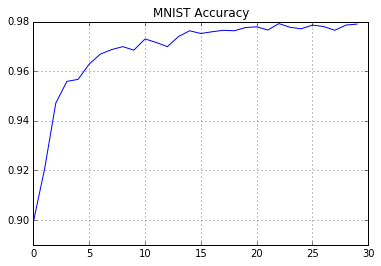

In [31]:
plt.plot(top1)
plt.grid()
plt.title('MNIST Accuracy')

### Great! We have reached 98 % accuracy. Let's add another hidden layer and see if we can improve the result by keeping our already trained layers fixed and only training the new layer:

In [32]:
def mnist_model_with_additional_layer(inputs, train=True, **kwargs):
    # not trainable variables; Note how we set trainable=False
    with tf.variable_scope("mnist"):
        W1 = tf.get_variable('W1', [784,128], tf.float32, tf.random_normal_initializer(stddev=0.1), trainable=False)
        b1 = tf.get_variable('b1', [128], tf.float32, tf.random_normal_initializer(stddev=0.1), trainable=False)
        W2 = tf.get_variable('W2', [128,32], tf.float32, tf.random_normal_initializer(stddev=0.1), trainable=False)
        b2 = tf.get_variable('b2', [32], tf.float32, tf.random_normal_initializer(stddev=0.1), trainable=False)
        W3 = tf.get_variable('W3', [32,10], tf.float32, tf.random_normal_initializer(stddev=0.1), trainable=False)
        b3 = tf.get_variable('b3', [10], tf.float32, tf.random_normal_initializer(stddev=0.1), trainable=False) 
        
        # hidden layers
        h1 = tf.nn.sigmoid(tf.matmul(inputs['images'], W1) + b1, name='hidden1')
        h2 = tf.nn.sigmoid(tf.matmul(h1, W2) + b2, name='hidden2')
    
        output = tf.nn.sigmoid(tf.matmul(h2, W3) + b3, name='hidden3')
    
        # new layer, trainable, randomly initialized
        W4 = tf.get_variable('W4', [10,10], tf.float32, tf.random_normal_initializer(stddev=0.1))
        b4 = tf.get_variable('b4', [10], tf.float32, tf.random_normal_initializer(stddev=0.1))
        output = tf.matmul(output, W4) + b4

    return output, {}

params = {}

params['load_params'] = {
    'host': 'localhost',
    'port': 24444,
    'dbname': 'mnist',
    'collname': 'simple',
    'exp_id': 'exp1',
    'do_restore': True}

params['save_params'] = {
    'host': 'localhost',
    'port': 24444,
    'dbname': 'mnist',
    'collname': 'simple',
    'exp_id': 'exp1',
    'save_valid_freq': 100,
    'save_filters_freq': 100,
    'cache_filters_freq': 100}

params['train_params'] = {
    'data_params': {'func': data.MNIST,
                    'batch_size': 256,
                    'group': 'train',
                    'n_threads': 1},
    'queue_params': {'queue_type': 'random',
                     'batch_size': 256},
    'num_steps': 5000}

params['learning_rate_params'] = {
    'learning_rate': 0.5,
    'decay_steps': 500,
    'decay_rate': 0.95,
    'staircase': True}

params['optimizer_params'] = {
    'func': optimizer.ClipOptimizer,
    'optimizer_class': tf.train.MomentumOptimizer,
    'momentum': 0.9,
    'clip': True,
}

params['loss_params'] = {
    'targets': ['labels'],
    'loss_per_case_func': tf.nn.sparse_softmax_cross_entropy_with_logits,
    'agg_func': tf.reduce_mean
}

params['validation_params'] = {'valid0': {
    'data_params': {'func': data.MNIST,
                    'batch_size': 100,
                    'group': 'test',
                    'n_threads': 1},
    'queue_params': {'queue_type': 'fifo',
                     'batch_size': 100},
    'targets': {'func': top1_func},
    'num_steps': 100,
    'agg_func': agg_mean,
    'online_agg_func': online_agg,}}

params['model_params'] = {
    'func': mnist_model_with_additional_layer}

params['skip_check'] = True

base.train_from_params(**params)

# Extract record from database
q_val = {'exp_id' : 'exp1', 'validation_results' : {'$exists' : True}}
val_steps = connection['mnist']['simple.files'].find(q_val, projection = ['validation_results'])
top1 = [val_steps[i]['validation_results']['valid0']['top1'] 
        for i in range(val_steps.count())]
print(top1)

INFO:tfutils:No seed specified for model 0... Defaulting to seed: 0.
INFO:tfutils:No prefix specified for model 0... Defaulting to prefix: model_0.
INFO:tfutils:No devices specified for model 0... Defaulting to gpus: ['/gpu:0'].
INFO:tfutils:thres_loss not specified for model 0... Defaulting thres_loss to: 100.
INFO:tfutils:train_loop not specified for model 0... Using default training loop.
INFO:tfutils:validate_fist not specified for model 0... Defaulting validate_first to: True.
INFO:tfutils:minibatch_size not specified for training data_params... Defaulting minibatch_size to: 256 (identical to the batch size).


Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


INFO:tfutils:Initialized from scratch first
INFO:tfutils:Loading checkpoint from mnist.simple.files
INFO:tfutils:Cache file found at /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-3000, using that to load
INFO:tfutils:Restoring variables from record 59dea4491742f953d01dc626 (step 3000)...
INFO:tfutils:Saved Vars:
['global_step', 'mnist/W1/Momentum', 'mnist/b3/Momentum', 'mnist/b2', 'mnist/W3/Momentum', 'mnist/b1', 'Variable_5', 'mnist/b3', 'Variable_3', 'mnist/W1', 'Variable_1', 'mnist/W2/Momentum', 'Variable', 'Variable_4', 'mnist/b1/Momentum', 'mnist/W3', 'mnist/W2', 'mnist/b2/Momentum', 'Variable_2']
INFO:tfutils:No variable mapping specified.
INFO:tfutils:Saved shapes:
{'Variable_4': [32, 10], 'global_step': [], 'mnist/W1/Momentum': [784, 128], 'mnist/b3/Momentum': [10], 'mnist/W3/Momentum': [32, 10], 'mnist/b1': [128], 'mnist/b2': [32], 'mnist/b3': [10], 'Variable_3': [32], 'mnist/b2/Momentum': [32], 'Variable_1': [128], 'mnist/W2/Momentum': [128, 32], 'Variabl

global_step
mnist/b4/Momentum
mnist/b1
mnist/b2
mnist/b3
mnist/b4
mnist/W4/Momentum
Variable_1
Variable
mnist/W4
mnist/W3
mnist/W2
mnist/W1


INFO:tfutils:... done restoring.
INFO:tfutils:Unrestored Vars:
[u'mnist/b4/Momentum', u'mnist/b4', u'mnist/W4/Momentum', u'Variable_1', u'Variable', u'mnist/W4']
INFO:tfutils:Training beginning ...
INFO:tfutils:Step 3001 (17 ms) -- loss: 2.3111, learning_rate: 0.3675
INFO:tfutils:Step 3002 (6 ms) -- loss: 2.2960, learning_rate: 0.3675
INFO:tfutils:Step 3003 (4 ms) -- loss: 2.2133, learning_rate: 0.3675
INFO:tfutils:Step 3004 (5 ms) -- loss: 2.1118, learning_rate: 0.3675
INFO:tfutils:Step 3005 (5 ms) -- loss: 1.9932, learning_rate: 0.3675
INFO:tfutils:Step 3006 (3 ms) -- loss: 1.8898, learning_rate: 0.3675
INFO:tfutils:Step 3007 (4 ms) -- loss: 1.7964, learning_rate: 0.3675
INFO:tfutils:Step 3008 (4 ms) -- loss: 1.6739, learning_rate: 0.3675
INFO:tfutils:Step 3009 (5 ms) -- loss: 1.5816, learning_rate: 0.3675
INFO:tfutils:Step 3010 (5 ms) -- loss: 1.4316, learning_rate: 0.3675
INFO:tfutils:Step 3011 (3 ms) -- loss: 1.3293, learning_rate: 0.3675
INFO:tfutils:Step 3012 (4 ms) -- loss: 1.2

INFO:tfutils:Step 3110 (4 ms) -- loss: 0.3613, learning_rate: 0.3675
INFO:tfutils:Step 3111 (4 ms) -- loss: 0.3434, learning_rate: 0.3675
INFO:tfutils:Step 3112 (4 ms) -- loss: 0.2602, learning_rate: 0.3675
INFO:tfutils:Step 3113 (5 ms) -- loss: 0.2659, learning_rate: 0.3675
INFO:tfutils:Step 3114 (4 ms) -- loss: 0.3826, learning_rate: 0.3675
INFO:tfutils:Step 3115 (8 ms) -- loss: 0.2903, learning_rate: 0.3675
INFO:tfutils:Step 3116 (4 ms) -- loss: 0.3973, learning_rate: 0.3675
INFO:tfutils:Step 3117 (5 ms) -- loss: 0.3468, learning_rate: 0.3675
INFO:tfutils:Step 3118 (4 ms) -- loss: 0.3352, learning_rate: 0.3675
INFO:tfutils:Step 3119 (5 ms) -- loss: 0.2915, learning_rate: 0.3675
INFO:tfutils:Step 3120 (5 ms) -- loss: 0.3070, learning_rate: 0.3675
INFO:tfutils:Step 3121 (3 ms) -- loss: 0.3258, learning_rate: 0.3675
INFO:tfutils:Step 3122 (4 ms) -- loss: 0.2892, learning_rate: 0.3675
INFO:tfutils:Step 3123 (4 ms) -- loss: 0.2995, learning_rate: 0.3675
INFO:tfutils:Step 3124 (8 ms) -- l

INFO:tfutils:Step 3222 (4 ms) -- loss: 0.4042, learning_rate: 0.3675
INFO:tfutils:Step 3223 (3 ms) -- loss: 0.3575, learning_rate: 0.3675
INFO:tfutils:Step 3224 (6 ms) -- loss: 0.3764, learning_rate: 0.3675
INFO:tfutils:Step 3225 (4 ms) -- loss: 0.2390, learning_rate: 0.3675
INFO:tfutils:Step 3226 (4 ms) -- loss: 0.2758, learning_rate: 0.3675
INFO:tfutils:Step 3227 (5 ms) -- loss: 0.2755, learning_rate: 0.3675
INFO:tfutils:Step 3228 (4 ms) -- loss: 0.3035, learning_rate: 0.3675
INFO:tfutils:Step 3229 (5 ms) -- loss: 0.3281, learning_rate: 0.3675
INFO:tfutils:Step 3230 (4 ms) -- loss: 0.2712, learning_rate: 0.3675
INFO:tfutils:Step 3231 (4 ms) -- loss: 0.3290, learning_rate: 0.3675
INFO:tfutils:Step 3232 (4 ms) -- loss: 0.2326, learning_rate: 0.3675
INFO:tfutils:Step 3233 (5 ms) -- loss: 0.3336, learning_rate: 0.3675
INFO:tfutils:Step 3234 (6 ms) -- loss: 0.3079, learning_rate: 0.3675
INFO:tfutils:Step 3235 (4 ms) -- loss: 0.2822, learning_rate: 0.3675
INFO:tfutils:Step 3236 (4 ms) -- l

INFO:tfutils:Step 3334 (4 ms) -- loss: 0.2647, learning_rate: 0.3675
INFO:tfutils:Step 3335 (4 ms) -- loss: 0.2834, learning_rate: 0.3675
INFO:tfutils:Step 3336 (5 ms) -- loss: 0.3069, learning_rate: 0.3675
INFO:tfutils:Step 3337 (4 ms) -- loss: 0.2380, learning_rate: 0.3675
INFO:tfutils:Step 3338 (4 ms) -- loss: 0.3133, learning_rate: 0.3675
INFO:tfutils:Step 3339 (4 ms) -- loss: 0.2200, learning_rate: 0.3675
INFO:tfutils:Step 3340 (5 ms) -- loss: 0.2731, learning_rate: 0.3675
INFO:tfutils:Step 3341 (5 ms) -- loss: 0.2787, learning_rate: 0.3675
INFO:tfutils:Step 3342 (5 ms) -- loss: 0.2842, learning_rate: 0.3675
INFO:tfutils:Step 3343 (4 ms) -- loss: 0.3441, learning_rate: 0.3675
INFO:tfutils:Step 3344 (4 ms) -- loss: 0.2855, learning_rate: 0.3675
INFO:tfutils:Step 3345 (4 ms) -- loss: 0.2327, learning_rate: 0.3675
INFO:tfutils:Step 3346 (4 ms) -- loss: 0.3148, learning_rate: 0.3675
INFO:tfutils:Step 3347 (5 ms) -- loss: 0.3096, learning_rate: 0.3675
INFO:tfutils:Step 3348 (6 ms) -- l

INFO:tfutils:Step 3446 (3 ms) -- loss: 0.2984, learning_rate: 0.3675
INFO:tfutils:Step 3447 (4 ms) -- loss: 0.2631, learning_rate: 0.3675
INFO:tfutils:Step 3448 (4 ms) -- loss: 0.2648, learning_rate: 0.3675
INFO:tfutils:Step 3449 (4 ms) -- loss: 0.2777, learning_rate: 0.3675
INFO:tfutils:Step 3450 (3 ms) -- loss: 0.2346, learning_rate: 0.3675
INFO:tfutils:Step 3451 (3 ms) -- loss: 0.2338, learning_rate: 0.3675
INFO:tfutils:Step 3452 (5 ms) -- loss: 0.3058, learning_rate: 0.3675
INFO:tfutils:Step 3453 (3 ms) -- loss: 0.2683, learning_rate: 0.3675
INFO:tfutils:Step 3454 (3 ms) -- loss: 0.3012, learning_rate: 0.3675
INFO:tfutils:Step 3455 (4 ms) -- loss: 0.2333, learning_rate: 0.3675
INFO:tfutils:Step 3456 (4 ms) -- loss: 0.2508, learning_rate: 0.3675
INFO:tfutils:Step 3457 (4 ms) -- loss: 0.2932, learning_rate: 0.3675
INFO:tfutils:Step 3458 (3 ms) -- loss: 0.2368, learning_rate: 0.3675
INFO:tfutils:Step 3459 (4 ms) -- loss: 0.2738, learning_rate: 0.3675
INFO:tfutils:Step 3460 (3 ms) -- l

INFO:tfutils:Step 3558 (3 ms) -- loss: 0.2477, learning_rate: 0.3492
INFO:tfutils:Step 3559 (4 ms) -- loss: 0.1892, learning_rate: 0.3492
INFO:tfutils:Step 3560 (3 ms) -- loss: 0.2538, learning_rate: 0.3492
INFO:tfutils:Step 3561 (4 ms) -- loss: 0.2651, learning_rate: 0.3492
INFO:tfutils:Step 3562 (3 ms) -- loss: 0.2016, learning_rate: 0.3492
INFO:tfutils:Step 3563 (3 ms) -- loss: 0.2318, learning_rate: 0.3492
INFO:tfutils:Step 3564 (3 ms) -- loss: 0.3026, learning_rate: 0.3492
INFO:tfutils:Step 3565 (3 ms) -- loss: 0.3206, learning_rate: 0.3492
INFO:tfutils:Step 3566 (4 ms) -- loss: 0.2513, learning_rate: 0.3492
INFO:tfutils:Step 3567 (3 ms) -- loss: 0.2258, learning_rate: 0.3492
INFO:tfutils:Step 3568 (3 ms) -- loss: 0.2593, learning_rate: 0.3492
INFO:tfutils:Step 3569 (4 ms) -- loss: 0.2268, learning_rate: 0.3492
INFO:tfutils:Step 3570 (4 ms) -- loss: 0.2725, learning_rate: 0.3492
INFO:tfutils:Step 3571 (3 ms) -- loss: 0.2185, learning_rate: 0.3492
INFO:tfutils:Step 3572 (3 ms) -- l

INFO:tfutils:Step 3670 (4 ms) -- loss: 0.2439, learning_rate: 0.3492
INFO:tfutils:Step 3671 (3 ms) -- loss: 0.2572, learning_rate: 0.3492
INFO:tfutils:Step 3672 (4 ms) -- loss: 0.2483, learning_rate: 0.3492
INFO:tfutils:Step 3673 (4 ms) -- loss: 0.2674, learning_rate: 0.3492
INFO:tfutils:Step 3674 (4 ms) -- loss: 0.2732, learning_rate: 0.3492
INFO:tfutils:Step 3675 (4 ms) -- loss: 0.2690, learning_rate: 0.3492
INFO:tfutils:Step 3676 (4 ms) -- loss: 0.2788, learning_rate: 0.3492
INFO:tfutils:Step 3677 (4 ms) -- loss: 0.2307, learning_rate: 0.3492
INFO:tfutils:Step 3678 (4 ms) -- loss: 0.2645, learning_rate: 0.3492
INFO:tfutils:Step 3679 (5 ms) -- loss: 0.2583, learning_rate: 0.3492
INFO:tfutils:Step 3680 (4 ms) -- loss: 0.2606, learning_rate: 0.3492
INFO:tfutils:Step 3681 (4 ms) -- loss: 0.2293, learning_rate: 0.3492
INFO:tfutils:Step 3682 (3 ms) -- loss: 0.2618, learning_rate: 0.3492
INFO:tfutils:Step 3683 (4 ms) -- loss: 0.2505, learning_rate: 0.3492
INFO:tfutils:Step 3684 (4 ms) -- l

INFO:tfutils:Step 3782 (4 ms) -- loss: 0.2472, learning_rate: 0.3492
INFO:tfutils:Step 3783 (4 ms) -- loss: 0.2020, learning_rate: 0.3492
INFO:tfutils:Step 3784 (5 ms) -- loss: 0.2039, learning_rate: 0.3492
INFO:tfutils:Step 3785 (4 ms) -- loss: 0.2688, learning_rate: 0.3492
INFO:tfutils:Step 3786 (4 ms) -- loss: 0.3086, learning_rate: 0.3492
INFO:tfutils:Step 3787 (4 ms) -- loss: 0.2191, learning_rate: 0.3492
INFO:tfutils:Step 3788 (4 ms) -- loss: 0.2823, learning_rate: 0.3492
INFO:tfutils:Step 3789 (3 ms) -- loss: 0.2496, learning_rate: 0.3492
INFO:tfutils:Step 3790 (4 ms) -- loss: 0.2433, learning_rate: 0.3492
INFO:tfutils:Step 3791 (3 ms) -- loss: 0.1776, learning_rate: 0.3492
INFO:tfutils:Step 3792 (7 ms) -- loss: 0.2659, learning_rate: 0.3492
INFO:tfutils:Step 3793 (4 ms) -- loss: 0.2342, learning_rate: 0.3492
INFO:tfutils:Step 3794 (4 ms) -- loss: 0.2375, learning_rate: 0.3492
INFO:tfutils:Step 3795 (3 ms) -- loss: 0.2747, learning_rate: 0.3492
INFO:tfutils:Step 3796 (3 ms) -- l

INFO:tfutils:Step 3894 (5 ms) -- loss: 0.2485, learning_rate: 0.3492
INFO:tfutils:Step 3895 (4 ms) -- loss: 0.2712, learning_rate: 0.3492
INFO:tfutils:Step 3896 (4 ms) -- loss: 0.2385, learning_rate: 0.3492
INFO:tfutils:Step 3897 (4 ms) -- loss: 0.2566, learning_rate: 0.3492
INFO:tfutils:Step 3898 (4 ms) -- loss: 0.2712, learning_rate: 0.3492
INFO:tfutils:Step 3899 (4 ms) -- loss: 0.2033, learning_rate: 0.3492
valid0: 100%|██████████| 100/100 [00:00<00:00, 687.16it/s]
INFO:tfutils:Step 3900 (152 ms) -- loss: 0.2432, learning_rate: 0.3492
INFO:tfutils:Validation -- valid0: {}
INFO:tfutils:Saving model with path prefix /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint ... 
INFO:tfutils:Step 3901 (6 ms) -- loss: 0.3036, learning_rate: 0.3492
INFO:tfutils:Step 3902 (4 ms) -- loss: 0.2629, learning_rate: 0.3492
INFO:tfutils:Step 3903 (4 ms) -- loss: 0.2376, learning_rate: 0.3492
INFO:tfutils:Step 3904 (4 ms) -- loss: 0.2375, learning_rate: 0.3492
INFO:tfutils:Step 3905 (4 m

INFO:tfutils:Step 4003 (6 ms) -- loss: 0.2586, learning_rate: 0.3317
INFO:tfutils:... done saving with path prefix /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-4000
INFO:tfutils:Putting filters into <gridfs.GridFS object at 0x7fde32ea2f90> database
INFO:tfutils:Step 4004 (5 ms) -- loss: 0.2044, learning_rate: 0.3317
INFO:tfutils:Step 4005 (5 ms) -- loss: 0.2379, learning_rate: 0.3317
INFO:tfutils:Step 4006 (4 ms) -- loss: 0.2747, learning_rate: 0.3317
INFO:tfutils:... done putting filters into database.
INFO:tfutils:Step 4007 (5 ms) -- loss: 0.2799, learning_rate: 0.3317
INFO:tfutils:Step 4008 (5 ms) -- loss: 0.3069, learning_rate: 0.3317
INFO:tfutils:Step 4009 (5 ms) -- loss: 0.2440, learning_rate: 0.3317
INFO:tfutils:Step 4010 (4 ms) -- loss: 0.2854, learning_rate: 0.3317
INFO:tfutils:Step 4011 (4 ms) -- loss: 0.2151, learning_rate: 0.3317
INFO:tfutils:Step 4012 (4 ms) -- loss: 0.1881, learning_rate: 0.3317
INFO:tfutils:Step 4013 (4 ms) -- loss: 0.2845, learning

INFO:tfutils:Step 4112 (3 ms) -- loss: 0.2001, learning_rate: 0.3317
INFO:tfutils:Step 4113 (4 ms) -- loss: 0.2355, learning_rate: 0.3317
INFO:tfutils:Step 4114 (4 ms) -- loss: 0.2059, learning_rate: 0.3317
INFO:tfutils:Step 4115 (4 ms) -- loss: 0.2267, learning_rate: 0.3317
INFO:tfutils:Step 4116 (3 ms) -- loss: 0.2227, learning_rate: 0.3317
INFO:tfutils:Step 4117 (5 ms) -- loss: 0.2273, learning_rate: 0.3317
INFO:tfutils:Step 4118 (5 ms) -- loss: 0.2441, learning_rate: 0.3317
INFO:tfutils:Step 4119 (4 ms) -- loss: 0.2467, learning_rate: 0.3317
INFO:tfutils:Step 4120 (5 ms) -- loss: 0.2666, learning_rate: 0.3317
INFO:tfutils:Step 4121 (5 ms) -- loss: 0.2339, learning_rate: 0.3317
INFO:tfutils:Step 4122 (4 ms) -- loss: 0.3120, learning_rate: 0.3317
INFO:tfutils:Step 4123 (4 ms) -- loss: 0.2151, learning_rate: 0.3317
INFO:tfutils:Step 4124 (4 ms) -- loss: 0.1850, learning_rate: 0.3317
INFO:tfutils:Step 4125 (4 ms) -- loss: 0.1706, learning_rate: 0.3317
INFO:tfutils:Step 4126 (4 ms) -- l

INFO:tfutils:Step 4224 (4 ms) -- loss: 0.2172, learning_rate: 0.3317
INFO:tfutils:Step 4225 (5 ms) -- loss: 0.2049, learning_rate: 0.3317
INFO:tfutils:Step 4226 (4 ms) -- loss: 0.1933, learning_rate: 0.3317
INFO:tfutils:Step 4227 (6 ms) -- loss: 0.2000, learning_rate: 0.3317
INFO:tfutils:Step 4228 (4 ms) -- loss: 0.2910, learning_rate: 0.3317
INFO:tfutils:Step 4229 (4 ms) -- loss: 0.2282, learning_rate: 0.3317
INFO:tfutils:Step 4230 (6 ms) -- loss: 0.1710, learning_rate: 0.3317
INFO:tfutils:Step 4231 (5 ms) -- loss: 0.2434, learning_rate: 0.3317
INFO:tfutils:Step 4232 (4 ms) -- loss: 0.2297, learning_rate: 0.3317
INFO:tfutils:Step 4233 (6 ms) -- loss: 0.2618, learning_rate: 0.3317
INFO:tfutils:Step 4234 (5 ms) -- loss: 0.2789, learning_rate: 0.3317
INFO:tfutils:Step 4235 (5 ms) -- loss: 0.2076, learning_rate: 0.3317
INFO:tfutils:Step 4236 (6 ms) -- loss: 0.2011, learning_rate: 0.3317
INFO:tfutils:Step 4237 (4 ms) -- loss: 0.2747, learning_rate: 0.3317
INFO:tfutils:Step 4238 (3 ms) -- l

INFO:tfutils:Step 4336 (4 ms) -- loss: 0.1542, learning_rate: 0.3317
INFO:tfutils:Step 4337 (4 ms) -- loss: 0.2755, learning_rate: 0.3317
INFO:tfutils:Step 4338 (7 ms) -- loss: 0.2432, learning_rate: 0.3317
INFO:tfutils:Step 4339 (5 ms) -- loss: 0.1973, learning_rate: 0.3317
INFO:tfutils:Step 4340 (4 ms) -- loss: 0.2280, learning_rate: 0.3317
INFO:tfutils:Step 4341 (4 ms) -- loss: 0.1964, learning_rate: 0.3317
INFO:tfutils:Step 4342 (4 ms) -- loss: 0.2472, learning_rate: 0.3317
INFO:tfutils:Step 4343 (4 ms) -- loss: 0.2020, learning_rate: 0.3317
INFO:tfutils:Step 4344 (3 ms) -- loss: 0.2510, learning_rate: 0.3317
INFO:tfutils:Step 4345 (4 ms) -- loss: 0.2270, learning_rate: 0.3317
INFO:tfutils:Step 4346 (5 ms) -- loss: 0.2790, learning_rate: 0.3317
INFO:tfutils:Step 4347 (4 ms) -- loss: 0.2729, learning_rate: 0.3317
INFO:tfutils:Step 4348 (4 ms) -- loss: 0.1940, learning_rate: 0.3317
INFO:tfutils:Step 4349 (4 ms) -- loss: 0.1976, learning_rate: 0.3317
INFO:tfutils:Step 4350 (3 ms) -- l

INFO:tfutils:Step 4448 (4 ms) -- loss: 0.2451, learning_rate: 0.3317
INFO:tfutils:Step 4449 (3 ms) -- loss: 0.2029, learning_rate: 0.3317
INFO:tfutils:Step 4450 (4 ms) -- loss: 0.2628, learning_rate: 0.3317
INFO:tfutils:Step 4451 (4 ms) -- loss: 0.2653, learning_rate: 0.3317
INFO:tfutils:Step 4452 (5 ms) -- loss: 0.2313, learning_rate: 0.3317
INFO:tfutils:Step 4453 (3 ms) -- loss: 0.2277, learning_rate: 0.3317
INFO:tfutils:Step 4454 (3 ms) -- loss: 0.2271, learning_rate: 0.3317
INFO:tfutils:Step 4455 (3 ms) -- loss: 0.3580, learning_rate: 0.3317
INFO:tfutils:Step 4456 (4 ms) -- loss: 0.2007, learning_rate: 0.3317
INFO:tfutils:Step 4457 (3 ms) -- loss: 0.2232, learning_rate: 0.3317
INFO:tfutils:Step 4458 (3 ms) -- loss: 0.2552, learning_rate: 0.3317
INFO:tfutils:Step 4459 (3 ms) -- loss: 0.2310, learning_rate: 0.3317
INFO:tfutils:Step 4460 (3 ms) -- loss: 0.2569, learning_rate: 0.3317
INFO:tfutils:Step 4461 (3 ms) -- loss: 0.1869, learning_rate: 0.3317
INFO:tfutils:Step 4462 (3 ms) -- l

INFO:tfutils:Step 4560 (4 ms) -- loss: 0.2780, learning_rate: 0.3151
INFO:tfutils:Step 4561 (4 ms) -- loss: 0.2200, learning_rate: 0.3151
INFO:tfutils:Step 4562 (7 ms) -- loss: 0.1917, learning_rate: 0.3151
INFO:tfutils:Step 4563 (5 ms) -- loss: 0.2049, learning_rate: 0.3151
INFO:tfutils:Step 4564 (4 ms) -- loss: 0.1873, learning_rate: 0.3151
INFO:tfutils:Step 4565 (4 ms) -- loss: 0.2483, learning_rate: 0.3151
INFO:tfutils:Step 4566 (5 ms) -- loss: 0.2070, learning_rate: 0.3151
INFO:tfutils:Step 4567 (4 ms) -- loss: 0.2460, learning_rate: 0.3151
INFO:tfutils:Step 4568 (3 ms) -- loss: 0.1871, learning_rate: 0.3151
INFO:tfutils:Step 4569 (4 ms) -- loss: 0.1983, learning_rate: 0.3151
INFO:tfutils:Step 4570 (4 ms) -- loss: 0.2049, learning_rate: 0.3151
INFO:tfutils:Step 4571 (4 ms) -- loss: 0.2435, learning_rate: 0.3151
INFO:tfutils:Step 4572 (4 ms) -- loss: 0.2163, learning_rate: 0.3151
INFO:tfutils:Step 4573 (4 ms) -- loss: 0.2248, learning_rate: 0.3151
INFO:tfutils:Step 4574 (5 ms) -- l

INFO:tfutils:Step 4672 (3 ms) -- loss: 0.1547, learning_rate: 0.3151
INFO:tfutils:Step 4673 (3 ms) -- loss: 0.2486, learning_rate: 0.3151
INFO:tfutils:Step 4674 (3 ms) -- loss: 0.2847, learning_rate: 0.3151
INFO:tfutils:Step 4675 (4 ms) -- loss: 0.1843, learning_rate: 0.3151
INFO:tfutils:Step 4676 (4 ms) -- loss: 0.1347, learning_rate: 0.3151
INFO:tfutils:Step 4677 (3 ms) -- loss: 0.2609, learning_rate: 0.3151
INFO:tfutils:Step 4678 (5 ms) -- loss: 0.2702, learning_rate: 0.3151
INFO:tfutils:Step 4679 (3 ms) -- loss: 0.2537, learning_rate: 0.3151
INFO:tfutils:Step 4680 (3 ms) -- loss: 0.2720, learning_rate: 0.3151
INFO:tfutils:Step 4681 (5 ms) -- loss: 0.2904, learning_rate: 0.3151
INFO:tfutils:Step 4682 (3 ms) -- loss: 0.2021, learning_rate: 0.3151
INFO:tfutils:Step 4683 (4 ms) -- loss: 0.2110, learning_rate: 0.3151
INFO:tfutils:Step 4684 (4 ms) -- loss: 0.2725, learning_rate: 0.3151
INFO:tfutils:Step 4685 (4 ms) -- loss: 0.1839, learning_rate: 0.3151
INFO:tfutils:Step 4686 (3 ms) -- l

INFO:tfutils:Step 4784 (4 ms) -- loss: 0.2097, learning_rate: 0.3151
INFO:tfutils:Step 4785 (4 ms) -- loss: 0.1946, learning_rate: 0.3151
INFO:tfutils:Step 4786 (4 ms) -- loss: 0.1841, learning_rate: 0.3151
INFO:tfutils:Step 4787 (5 ms) -- loss: 0.2520, learning_rate: 0.3151
INFO:tfutils:Step 4788 (4 ms) -- loss: 0.1985, learning_rate: 0.3151
INFO:tfutils:Step 4789 (3 ms) -- loss: 0.2222, learning_rate: 0.3151
INFO:tfutils:Step 4790 (4 ms) -- loss: 0.1546, learning_rate: 0.3151
INFO:tfutils:Step 4791 (3 ms) -- loss: 0.2227, learning_rate: 0.3151
INFO:tfutils:Step 4792 (4 ms) -- loss: 0.2484, learning_rate: 0.3151
INFO:tfutils:Step 4793 (3 ms) -- loss: 0.2213, learning_rate: 0.3151
INFO:tfutils:Step 4794 (5 ms) -- loss: 0.2308, learning_rate: 0.3151
INFO:tfutils:Step 4795 (4 ms) -- loss: 0.2133, learning_rate: 0.3151
INFO:tfutils:Step 4796 (12 ms) -- loss: 0.2257, learning_rate: 0.3151
INFO:tfutils:Step 4797 (5 ms) -- loss: 0.2264, learning_rate: 0.3151
INFO:tfutils:Step 4798 (6 ms) -- 

INFO:tfutils:Step 4896 (4 ms) -- loss: 0.2373, learning_rate: 0.3151
INFO:tfutils:Step 4897 (5 ms) -- loss: 0.2482, learning_rate: 0.3151
INFO:tfutils:Step 4898 (6 ms) -- loss: 0.2112, learning_rate: 0.3151
INFO:tfutils:Step 4899 (5 ms) -- loss: 0.1872, learning_rate: 0.3151
valid0: 100%|██████████| 100/100 [00:00<00:00, 886.23it/s]
INFO:tfutils:Step 4900 (119 ms) -- loss: 0.1706, learning_rate: 0.3151
INFO:tfutils:Validation -- valid0: {}
INFO:tfutils:Saving model with path prefix /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint ... 
INFO:tfutils:Step 4901 (6 ms) -- loss: 0.1726, learning_rate: 0.3151
INFO:tfutils:Step 4902 (5 ms) -- loss: 0.2006, learning_rate: 0.3151
INFO:tfutils:... done saving with path prefix /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-4900
INFO:tfutils:Putting filters into <gridfs.GridFS object at 0x7fde32ea2f90> database
INFO:tfutils:Step 4903 (5 ms) -- loss: 0.2539, learning_rate: 0.3151
INFO:tfutils:Step 4904 (8 ms) --

[0.8994, 0.9206, 0.9471, 0.9559, 0.9567, 0.9629, 0.9669, 0.9687, 0.9699, 0.9685, 0.973, 0.9716, 0.9699, 0.974, 0.9763, 0.9752, 0.9759, 0.9765, 0.9763, 0.9776, 0.9779, 0.9766, 0.9792, 0.9777, 0.9771, 0.9786, 0.978, 0.9765, 0.9786, 0.979, 0.8971, 0.9048, 0.9084, 0.9078, 0.9115, 0.9123, 0.9159, 0.9152, 0.9164, 0.9163, 0.9165, 0.9175, 0.9184, 0.9162, 0.9184, 0.9205, 0.9197, 0.9213, 0.9205, 0.9222]


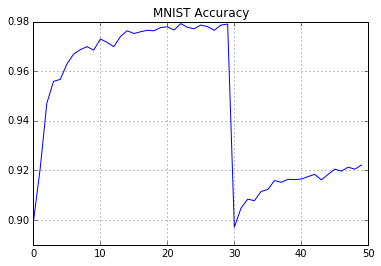

In [33]:
plt.plot(top1)
plt.grid()
plt.title('MNIST Accuracy')

### This clearly did not work. Although the performance keeps increasing after evaluation step 30 when the new layer was added, it seems to level off at 94 %. This was example only to illustrate how you can reload weights from your trained model, keep the trained layers fixed, add new layers and only train the newly added layers. So let's not do it again. 

### The last thing that we will show you in TFUtils is how to extract features from the model graph.


In [34]:
import re
from collections import defaultdict

def get_extraction_target(inputs, outputs, to_extract, **loss_params):
    names = [[x.name for x in op.values()] for op in tf.get_default_graph().get_operations()]
    names = [y for x in names for y in x]

    #print('nodes in graph: ', names)
    r = re.compile(r'__GPU__\d/')
    _targets = defaultdict(list)

    for name in names:
        name_without_gpu_prefix = r.sub('', name)
        for save_name, actual_name in to_extract.items():
            if actual_name in name_without_gpu_prefix:
                tensor = tf.get_default_graph().get_tensor_by_name(name)
                _targets[save_name].append(tensor)

    targets = {k: tf.concat(v, axis=0) for k, v in _targets.items()}
    return targets

def online_agg_no_mean(agg_res, res, step):
    """
    Appends the value for each key
    """
    if agg_res is None:
        agg_res = {k: [] for k in res}
    for k, v in res.items():
        agg_res[k].append(v)
    return agg_res

def agg_no_mean(x):
    return {k: v for k, v in x.items()}

params = {}

params['load_params'] = {
    'host': 'localhost',
    'port': 24444,
    'dbname': 'mnist',
    'collname': 'simple',
    'exp_id': 'exp1',
    'do_restore': True}

params['validation_params'] = {'valid0': {
    'data_params': {'func': data.MNIST,
                    'batch_size': 1,
                    'group': 'test',
                    'n_threads': 1},
    'queue_params': {'queue_type': 'fifo',
                     'batch_size': 1},
    'targets': {'func': get_extraction_target,
               'to_extract': {
                   'W2': 'mnist/W2:0',
                   'hidden2': 'model_0/validation/valid0/mnist/hidden2:0'}},
    'num_steps': 1,
    'agg_func': agg_no_mean, # we do not want to mean the features that we extract
    'online_agg_func': online_agg_no_mean,}}

params['model_params'] = {
    'func': mnist_model}

params['skip_check'] = True

base.test_from_params(**params)

# print shape of retrieved weights and activations
q_val = {'exp_id' : 'exp1', 'validation_results' : {'$exists' : True}, 'validates': {'$exists' : True}}
val_steps = connection['mnist']['simple.files'].find(q_val, projection = ['validation_results'])
idx = val_steps.count() - 1
print('W2', np.array(val_steps[idx]['validation_results']['valid0']['W2'])[0].shape)
print('hidden2', np.array(val_steps[idx]['validation_results']['valid0']['hidden2'])[0].shape)

INFO:tfutils:No seed specified for model 0... Defaulting to seed: 0.
INFO:tfutils:No prefix specified for model 0... Defaulting to prefix: model_0.
INFO:tfutils:No devices specified for model 0... Defaulting to gpus: ['/gpu:0'].
INFO:tfutils:Initialized from scratch first
INFO:tfutils:Loading checkpoint from mnist.simple.files
INFO:tfutils:Cache file found at /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-5000, using that to load


Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


INFO:tfutils:Loading checkpoint from mnist.simple.files
INFO:tfutils:Cache file found at /home/mrowca/.tfutils/localhost:24444/mnist/simple/exp1/checkpoint-5000, using that to load
INFO:tfutils:Restoring variables from record 59dea49d1742f953d01dc666 (step 5000)...
INFO:tfutils:Saved Vars:
['global_step', 'mnist/b4/Momentum', 'mnist/b1', 'mnist/b2', 'mnist/b3', 'mnist/b4', 'mnist/W4/Momentum', 'Variable_1', 'Variable', 'mnist/W4', 'mnist/W3', 'mnist/W2', 'mnist/W1']
INFO:tfutils:No variable mapping specified.
INFO:tfutils:Saved shapes:
{'global_step': [], 'mnist/b4/Momentum': [10], 'mnist/b1': [128], 'mnist/b2': [32], 'mnist/b3': [10], 'mnist/b4': [10], 'mnist/W4/Momentum': [10, 10], 'Variable_1': [10], 'Variable': [10, 10], 'mnist/W4': [10, 10], 'mnist/W3': [32, 10], 'mnist/W2': [128, 32], 'mnist/W1': [784, 128]}
INFO:tfutils:Restored Vars:
[u'mnist/b1', u'mnist/b2', u'mnist/b3', u'mnist/W3', u'mnist/W2', u'mnist/W1']
INFO:tfutils:... done restoring.
INFO:tfutils:Unrestored Vars:
[]
v

('W2', (128, 32))
('hidden2', (1, 32))


### This concludes the tutorial on TFUtils. We will now diverge a little bit from deep learning and introduce some useful tools to analyze neural data, such as tabular, scikit-learn and dldata.

## 5.) Working with the tabular meta data from dldata
### During your analysis of the neural data, you will be working with our lab-internal python package "dldata". "dldata" contains stimuli in the form of images and the neural responses of a macaque to those images accompanied by some meta data. The meta data contains information about the composition of the stimuli such as which category is depicted or where the object is located. Meta data itself is a tabarray which allows for an easy way of subsetting the data. So let's first load the meta data and the IT features from a pickle file that we have created and have put on your instances and then learn how to subsample the data by using the meta data:

In [35]:
#load from tfrecords
import cPickle
data_path = '/home/mrowca/neural_data.pkl' # CHANGE THIS TO '/datasets/neural_data/neural_data.pkl'
with open(data_path) as f:
    data = cPickle.load(f)
meta = data['meta']
IT_features = data['IT']

### Now, let's list all the fields within meta...

In [36]:
meta.dtype.names

('obj',
 'rxz',
 'rxy',
 'ryz',
 'ty',
 'tz',
 's',
 'bg_id',
 'size',
 'var',
 '_id',
 'filename',
 'id',
 'category',
 'rxz_semantic',
 'rxy_semantic',
 'ryz_semantic')

### ...and have a look at the contents of 'obj':

In [37]:
meta['obj']

tabarray(['Apple_Fruit_obj', 'Apple_Fruit_obj', 'Apple_Fruit_obj', ...,
          'z3', 'z3', 'z3'],
         dtype='|S24')

### To get all unique entries we can use np.unique:

In [38]:
np.unique(meta['obj'])

tabarray(['Apple_Fruit_obj', 'Apricot_obj', 'BAHRAIN', 'Beetle', 'CGTG_L',
          'DTUG_L', 'ELEPHANT_M', 'GORILLA', 'LIONESS', 'MQUEEN_L',
          'Peach_obj', 'Pear_obj', 'SISTER_L', 'Strawberry_obj',
          'TURTLE_L', '_001', '_004', '_008', '_010', '_011', '_014',
          '_01_Airliner_2jetEngines', '_031', '_033', '_05_future', '_08',
          '_10', '_11', '_12', '_18', '_19_flyingBoat', '_37', '_38',
          '_44', 'alfa155', 'astra', 'bear', 'blCow', 'bmw325', 'bora_a',
          'breed_pug', 'celica', 'clio', 'cruiser', 'f16', 'face0001',
          'face0002', 'face0003', 'face0004', 'face0005', 'face0006',
          'face0007', 'face0008', 'hedgehog', 'junkers88', 'mig29',
          'motoryacht', 'raspberry_obj', 'rdbarren', 'sopwith', 'support',
          'walnut_obj', 'watermelon_obj', 'z3'],
         dtype='|S24')

### Let's see how many unique 'obj' there are:

In [39]:
len(np.unique(meta['obj']))

64

### Now let's look at the unique 'categories':

In [40]:
np.unique(meta['category'])

tabarray(['Animals', 'Boats', 'Cars', 'Chairs', 'Faces', 'Fruits',
          'Planes', 'Tables'],
         dtype='|S7')

### Let's say we want to find all 'Cars' in 'obj' now:

In [41]:
np.unique(meta[meta['category'] == 'Cars']['obj'])

tabarray(['Beetle', 'alfa155', 'astra', 'bmw325', 'bora_a', 'celica',
          'clio', 'z3'],
         dtype='|S24')

### We can also use intersections and unions to subselect our data. Let's say we want to find all 'Cars' and all 'Faces' in 'obj':

In [42]:
np.unique(meta[(meta['category'] == 'Cars') | (meta['category'] == 'Faces')]['obj'])

tabarray(['Beetle', 'alfa155', 'astra', 'bmw325', 'bora_a', 'celica',
          'clio', 'face0001', 'face0002', 'face0003', 'face0004',
          'face0005', 'face0006', 'face0007', 'face0008', 'z3'],
         dtype='|S24')

### Now let's find out how many images have an object on the left side of the image:

In [43]:
len((meta['ty'] < 0).nonzero()[0])

2513

### We can also combine 'category' with 'ty' and look for e. g. all 'Cars' with at least one instance on the left side of the screen:

In [44]:
np.unique(meta[(meta['category'] == 'Cars') & (meta['ty'] < 0)]['obj'])

tabarray(['Beetle', 'alfa155', 'astra', 'bmw325', 'bora_a', 'celica',
          'clio', 'z3'],
         dtype='|S24')

### To conclude you can combine the fields in a tabarray in any possible imaginable way you want using logical operators to subselect the data as you need it. This enables us to save and query data in a structured way.

## 6.) Training and testing a classifier with scikit-learn and dldata
### During the analysis of neural responses it useful to see how well the recorded features can be used to disentangle object categories using a simple linear classifier. In the following we will thus show you how to train a linear support vector classifier on top of IT features to perform a basic 8-way classification task using scikit-learn:

In [45]:
from sklearn.svm import LinearSVC

# Create a random train / test split and 
# use 75 % of the V0 data for training and the rest for testing
v0_inds = (meta['var'] == 'V0').nonzero()[0]
n = len(v0_inds)
train_inds = np.random.RandomState(0).permutation(n)[: int(3 * n / 4)]
test_inds = np.random.RandomState(0).permutation(n)[int(3 * n / 4): ]
train_inds = v0_inds[train_inds]
test_inds = v0_inds[test_inds]

# Subselect the train and test IT features
train_features = IT_features[train_inds]
test_features = IT_features[test_inds]

# Subselect the train and test category labels
train_labels = meta['category'][train_inds]
test_labels = meta['category'][test_inds]

# Convert labels to integers
cat_id = dict([(category, i) for i, category in enumerate(np.unique(meta['category']))])
train_labels = np.array([cat_id[label] for label in train_labels])
test_labels = np.array([cat_id[label] for label in test_labels])

# Train LinearSVC (Linear Support Vector Classifier)
cls = LinearSVC(C = 5e-3)
cls.fit(train_features, train_labels)

# Test LinearSVC
prediction = cls.predict(test_features)
accuracy = np.sum(prediction == test_labels) / len(test_labels) * 100

# Print results
print('Overall accuracy of IT features on 8-way classification task: %.2f%%' % accuracy)

Overall accuracy of IT features on 8-way classification task: 88.75%


### As you can see a significant amount of code is needed to perform a classification experiment on only one split! All of this code is abstracted away in dldata to a simple function called "compute_metric_base" which takes care of everything we need including the creation of multiple train / test splits. This means that we can setup the same experiment with a simple spec that we then pass on to "compute_metric_base" to perform our classification experiment with multiple splits as follows: 

In [46]:
from dldata.metrics.utils import compute_metric_base
# Definition of classification experiment
category_eval_spec = {
    'npc_train': None,
    'npc_test': 2,
    'num_splits': 20,
    'npc_validate': 0,
    'metric_screen': 'classifier',
    'metric_labels': None,
    'metric_kwargs': {'model_type': 'svm.LinearSVC',
                      'model_kwargs': {'C':5e-3}
                     },
    'labelfunc': 'category',
    'train_q': {'var': ['V0']},
    'test_q': {'var': ['V0']},
    'split_by': 'obj'
}
# Execute classification experiment
res = compute_metric_base(IT_features, meta, category_eval_spec)

# Print results
print('Overall accuracy of IT features on 8-way classification task: %.2f%%' % \
      ((np.array(res['result_summary']['accbal']).mean(0) - 0.5) * 2.0 * 100.0))

Can't import separate mcc package
Can't import asgd.


/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/lda.py:6: DeprecationWarning: lda.LDA has been moved to discriminant_analysis.LinearDiscriminantAnalysis in 0.17 and will be removed in 0.19
  "in 0.17 and will be removed in 0.19", DeprecationWarning)
/usr/local/lib/python2.7/dist-pac

Overall accuracy of IT features on 8-way classification task: 90.80%


### 'compute_metric_base' also returns a bunch of other evaluation metrics such as dprime or the confusion matrix. Feel free to have a look at res['results_summary'] to see which metrics are returned. To plot the confusion matrix for instance, we can execute the following straight forward commands:

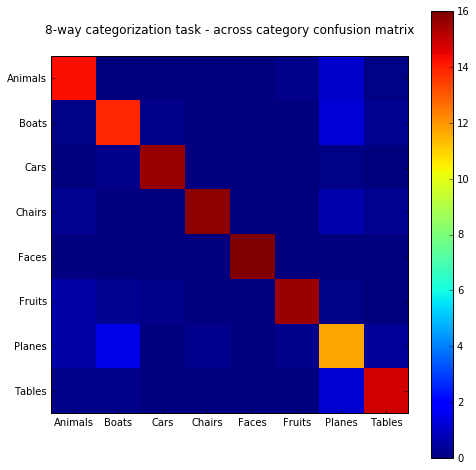

In [47]:
# Confusion matrix
fig = plt.figure(figsize=(8, 8))
m = fig.gca().matshow(np.array(res['result_summary']['cms']).mean(2))
plt.xticks(range(8), res['result_summary']['labelset'])
plt.yticks(range(8), res['result_summary']['labelset'])
plt.colorbar(m)
plt.title('8-way categorization task - across category confusion matrix')
ax = plt.gca()
ax.xaxis.tick_bottom()

### This example hopefully made it clear why it is simpler to use "compute_metric_base" for simple classification or regression experiments. Nonetheless, we wanted to show you the inner workings of "compute_metric_base", so you can implement your own machine learning tools with scikit-learn in case that the particular functionality you are looking for is not implemented in "compute_metric_base".

## 7.) Putting everything together
### At this point, you should have learned everything needed to setup a large-scale deep learning experiment and be able to understand most of the code in assignment 1 which is a great example of how everything that we have discussed fits together. Please have a look at the code of assignment 1. Conceptually, we have setup assignment 1 in the following way:  
### 1.) We generated TFRecord files for the ImageNet dataset and the neural data including all of the meta data needed and wrote dataproviders that read those TFRecords into TFUtils in "dataprovider.py".  
### 2.) We then wrote the "train_imagenet.py" script which specifies a TFUtils training experiment to train AlexNet on ImageNet saving the training results into our database. While the experiment is running the accuracy on the ImageNet classification task is evaluated and stored into the database to see if the model is training correctly.
### 3.) We then created "test_imagenet.py" which pulls the pretrained AlexNet model from the database and evaluates it using among others "compute_metric_base" from dldata with the help of the meta data that is read from the TFRecords and piped through the network. Essentially, we aggregate all of our network activations for all neural stimuli in our "agg_func" "neural_analysis" and perform our classification and regression experiments on the aggregated data. We store the evaluation results in the database.
### 4.) Finally, we pull the evaluation results from the database in our Jupyter notebook, and evaluate and visualize them. 
### In general, this is how most of the experiments are done in our lab. TFRecords allow us to read data fast. TFUtils helps us to keep organized. And Jupyter notebooks are a great and interactive way to visualize results.
### This concludes this tutorial on CNNs and Neural data. Good luck on assignment 1!